In [37]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from datetime import date
from KL_divergence import get_evaluation_policy, get_kl_max

from ope.envs.graph import Graph
from ope.models.basics import BasicPolicy

from ope.experiment_tools.experiment import ExperimentRunner, analysis
from ope.experiment_tools.config import Config
from ope.utils import make_seed
from neurips_seeds import weighted_graph_args, unweighted_graph_args
from neurips_plotting import neurips_plot, neurips_plot_kl_2D
import json


In [38]:

def run(experiment_args, kl_target):

    runner = ExperimentRunner()

    seeds  = []
    all_N_vals = []
    for t in range(experiment_args["num_trials"]): # Number of trials, config file for each trial.

        # Set random seed for trial.
        if experiment_args["seeds"] is None: seed = make_seed()
        else: seed = experiment_args["seeds"][t]
        seeds.append(seed)

        # For each trial, generate a single large dataset with the largest Nval.
        # For each Nval, we will compute the estimate for that value on the same dataset.
        max_Nval = max(experiment_args["Nvals"])
        all_N_vals += experiment_args["Nvals"]

        
        # basic configuration with varying number of trajectories
        configuration = {
            "gamma": experiment_args["gamma"],
            "horizon": experiment_args["horizon"],
            "base_policy": experiment_args["p0"],
            "eval_policy": experiment_args["p1"],
            "stochastic_env": True,
            "stochastic_rewards": False,
            "sparse_rewards": False,
            "num_traj": max_Nval,
            "Nvals": experiment_args["Nvals"], # Compute value of estimate for these data sizes
            "is_pomdp": False,
            "pomdp_horizon": 2,
            "seed": seed,
            "experiment_number": 0,
            "access": 0,
            "secret": 0,
            "modeltype": "tabular",
            "to_regress_pi_b": False,
            "nstep_int": 1,
            "weighted": experiment_args["weighted"]
        }

        # store them
        cfg = Config(configuration)


        # initialize environment with this configuration
        env = Graph(make_pomdp=cfg.is_pomdp,
                    number_of_pomdp_states=cfg.pomdp_horizon,
                    transitions_deterministic=not cfg.stochastic_env,
                    max_length=cfg.horizon,
                    sparse_rewards=cfg.sparse_rewards,
                    stochastic_rewards=cfg.stochastic_rewards)

        # set seed for the experiment
        np.random.seed(cfg.seed)

        # processor processes the state for storage
        processor = lambda x: x

        # absorbing state for padding if episode ends before horizon is reached
        absorbing_state = processor(np.array([env.n_dim - 1]))

        # Calculated evaluation policy for the given kl_divergence
        cfg.eval_policy = get_evaluation_policy(env, kl_target, cfg.base_policy, 0)

        # Setup policies
        actions = [0, 1]
        pi_e = BasicPolicy(
            actions, [max(.001, cfg.eval_policy), 1 - max(.001, cfg.eval_policy)])
        pi_b = BasicPolicy(
            actions, [max(.001, cfg.base_policy), 1 - max(.001, cfg.base_policy)])

        # add env, policies, absorbing state and processor
        cfg.add({
            'env': env,
            'pi_e': pi_e,
            'pi_b': pi_b,
            'processor': processor,
            'absorbing_state': absorbing_state
        })

        # Decide which OPE methods to run.
        # Currently only all is available
        cfg.add({'models': experiment_args["models"]})

        # Add the configuration
        runner.add(cfg)

    # Run the configurations
    results = runner.run()

    return results, {'seeds':seeds, 'args': experiment_args}






Running  0.1  of  [0.1, 0.3]


100%|██████████| 1024/1024 [00:02<00:00, 343.25it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.72it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:03<00:00, 312.73it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:03<00:00, 331.64it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:03<00:00, 308.16it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:03<00:00, 331.02it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.30it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:03<00:00, 316.46it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.08it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:03<00:00, 337.43it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:03<00:00, 332.09it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.26it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:02<00:00, 352.18it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.87it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.70it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:03<00:00, 338.99it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:03<00:00, 322.50it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.40it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:03<00:00, 320.22it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.95it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.75it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:03<00:00, 325.20it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.82it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.74it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.29it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 352.96it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 351.24it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:03<00:00, 323.48it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.28it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 321.62it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.64it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:02<00:00, 351.72it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 320.99it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.38it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.05it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:03<00:00, 321.67it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:03<00:00, 261.27it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:03<00:00, 262.71it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:04<00:00, 241.09it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:03<00:00, 326.42it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:03<00:00, 334.65it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:03<00:00, 324.11it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.83it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:03<00:00, 286.84it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:02<00:00, 343.98it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.27it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:03<00:00, 321.21it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.78it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.77it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:03<00:00, 324.24it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:02<00:00, 355.66it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.67it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:03<00:00, 325.83it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.84it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:02<00:00, 353.22it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 318.44it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.07it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:03<00:00, 320.23it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:02<00:00, 346.83it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.88it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:03<00:00, 318.00it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.27it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:02<00:00, 350.47it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 324.49it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.88it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.44it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:03<00:00, 323.48it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 349.74it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:02<00:00, 346.76it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:03<00:00, 325.00it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.06it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 350.85it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:03<00:00, 325.21it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.30it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:03<00:00, 322.83it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:02<00:00, 342.38it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.75it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.71it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.93it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.70it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:03<00:00, 326.45it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.99it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.62it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:04<00:00, 243.81it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:03<00:00, 267.98it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.58it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:03<00:00, 319.51it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:03<00:00, 338.66it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:03<00:00, 318.69it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:02<00:00, 351.83it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.39it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:03<00:00, 322.29it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:02<00:00, 350.19it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.33it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:03<00:00, 320.37it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.19it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.25it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:03<00:00, 319.82it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:02<00:00, 352.78it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 317.86it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.52it/s]


V(pi_b):  -6.520257741365938 V(pi_b) Normalized:  -0.39232335238568605
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5437. Error:     0.0799
 NStep(t=1):    -8.2001. Error:     0.0037
 NStep(t=2):    -8.2221. Error:     0.0015
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2196. Error:     0.0017
 NStep(t=5):    -8.2364. Error:     0.0006
 NStep(t=6):    -8.1860. Error:     0.0056
 NStep(t=7):    -8.1184. Error:     0.0203
 NStep(t=8):    -8.0596. Error:     0.0406
 NStep(t=9):    -8.0882. Error:     0.0299
NStep(t=10):    -8.0477. Error:     0.0455
NStep(t=11):    -8.0519. Error:     0.0438
NStep(t=12):    -8.1182. Error:     0.0204
NStep(t=13):    -8.2192. Error:     0.0017
NStep(t=14):    -8.2401. Error:     0.0004
NStep(t=15):    -8.1958. Error:     0.0043
NStep(t=16):    -8.2058. Error:     0.0030
NStep(t=17):    -8.2325. Error:     0.0008
NStep(t=18):    -8.2316. Error

100%|██████████| 1024/1024 [00:03<00:00, 325.65it/s]


V(pi_b):  -6.6483765787470706 V(pi_b) Normalized:  -0.40003225190759245
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6474. Error:     0.1493
 NStep(t=1):    -8.3578. Error:     0.0094
 NStep(t=2):    -8.3648. Error:     0.0108
 NStep(t=3):    -8.3636. Error:     0.0105
 NStep(t=4):    -8.3844. Error:     0.0152
 NStep(t=5):    -8.4047. Error:     0.0206
 NStep(t=6):    -8.3925. Error:     0.0173
 NStep(t=7):    -8.3879. Error:     0.0161
 NStep(t=8):    -8.4631. Error:     0.0408
 NStep(t=9):    -8.5235. Error:     0.0689
NStep(t=10):    -8.5172. Error:     0.0656
NStep(t=11):    -8.4758. Error:     0.0461
NStep(t=12):    -8.4394. Error:     0.0318
NStep(t=13):    -8.4118. Error:     0.0227
NStep(t=14):    -8.4533. Error:     0.0369
NStep(t=15):    -8.4318. Error:     0.0292
NStep(t=16):    -8.4592. Error:     0.0393
NStep(t=17):    -8.4514. Error:     0.0362
NStep(t=18):    -8.4287. Erro

100%|██████████| 1024/1024 [00:03<00:00, 290.90it/s]


V(pi_b):  -6.824006487188206 V(pi_b) Normalized:  -0.4105998885244208
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8253. Error:     0.3183
 NStep(t=1):    -8.4827. Error:     0.0491
 NStep(t=2):    -8.4156. Error:     0.0239
 NStep(t=3):    -8.4153. Error:     0.0238
 NStep(t=4):    -8.4165. Error:     0.0242
 NStep(t=5):    -8.4154. Error:     0.0238
 NStep(t=6):    -8.4368. Error:     0.0309
 NStep(t=7):    -8.4968. Error:     0.0556
 NStep(t=8):    -8.5182. Error:     0.0661
 NStep(t=9):    -8.4867. Error:     0.0509
NStep(t=10):    -8.4839. Error:     0.0496
NStep(t=11):    -8.5689. Error:     0.0948
NStep(t=12):    -8.5751. Error:     0.0986
NStep(t=13):    -8.6495. Error:     0.1509
NStep(t=14):    -8.6650. Error:     0.1632
NStep(t=15):    -8.6814. Error:     0.1767
NStep(t=16):    -8.6746. Error:     0.1710
NStep(t=17):    -8.6916. Error:     0.1854
NStep(t=18):    -8.6934. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.66it/s]


V(pi_b):  -6.661712747188248 V(pi_b) Normalized:  -0.4008346880256663
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6698. Error:     0.1671
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3958. Error:     0.0181
 NStep(t=3):    -8.4662. Error:     0.0421
 NStep(t=4):    -8.5067. Error:     0.0603
 NStep(t=5):    -8.5849. Error:     0.1049
 NStep(t=6):    -8.5082. Error:     0.0611
 NStep(t=7):    -8.4534. Error:     0.0370
 NStep(t=8):    -8.4888. Error:     0.0519
 NStep(t=9):    -8.4859. Error:     0.0506
NStep(t=10):    -8.4941. Error:     0.0543
NStep(t=11):    -8.4725. Error:     0.0447
NStep(t=12):    -8.4963. Error:     0.0553
NStep(t=13):    -8.4740. Error:     0.0453
NStep(t=14):    -8.4694. Error:     0.0434
NStep(t=15):    -8.4478. Error:     0.0349
NStep(t=16):    -8.4474. Error:     0.0347
NStep(t=17):    -8.4577. Error:     0.0387
NStep(t=18):    -8.4443. Error:

100%|██████████| 1024/1024 [00:03<00:00, 312.33it/s]


V(pi_b):  -6.584671900178032 V(pi_b) Normalized:  -0.3961991468295067
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3777. Error:     0.0136
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4418. Error:     0.0327
 NStep(t=4):    -8.5275. Error:     0.0710
 NStep(t=5):    -8.5143. Error:     0.0641
 NStep(t=6):    -8.4867. Error:     0.0509
 NStep(t=7):    -8.5374. Error:     0.0763
 NStep(t=8):    -8.5052. Error:     0.0596
 NStep(t=9):    -8.5732. Error:     0.0975
NStep(t=10):    -8.5514. Error:     0.0843
NStep(t=11):    -8.5805. Error:     0.1020
NStep(t=12):    -8.6285. Error:     0.1350
NStep(t=13):    -8.6346. Error:     0.1395
NStep(t=14):    -8.6452. Error:     0.1476
NStep(t=15):    -8.5925. Error:     0.1098
NStep(t=16):    -8.5840. Error:     0.1043
NStep(t=17):    -8.6087. Error:     0.1208
NStep(t=18):    -8.6252. Error:

100%|██████████| 1024/1024 [00:03<00:00, 315.40it/s]


V(pi_b):  -6.545010004072933 V(pi_b) Normalized:  -0.3938126939224065
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5694. Error:     0.0950
 NStep(t=1):    -8.2008. Error:     0.0036
 NStep(t=2):    -8.2335. Error:     0.0008
 NStep(t=3):    -8.2289. Error:     0.0010
 NStep(t=4):    -8.2012. Error:     0.0036
 NStep(t=5):    -8.2155. Error:     0.0021
 NStep(t=6):    -8.2251. Error:     0.0013
 NStep(t=7):    -8.1551. Error:     0.0112
 NStep(t=8):    -8.1782. Error:     0.0069
 NStep(t=9):    -8.2186. Error:     0.0018
NStep(t=10):    -8.2743. Error:     0.0002
NStep(t=11):    -8.3380. Error:     0.0059
NStep(t=12):    -8.3937. Error:     0.0176
NStep(t=13):    -8.3837. Error:     0.0151
NStep(t=14):    -8.3732. Error:     0.0126
NStep(t=15):    -8.3754. Error:     0.0131
NStep(t=16):    -8.4164. Error:     0.0241
NStep(t=17):    -8.4137. Error:     0.0233
NStep(t=18):    -8.4008. Error:

100%|██████████| 1024/1024 [00:03<00:00, 341.18it/s]


V(pi_b):  -6.711890385567027 V(pi_b) Normalized:  -0.4038538722488095
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6338. Error:     0.1389
 NStep(t=1):    -8.2779. Error:     0.0003
 NStep(t=2):    -8.2551. Error:     0.0000
 NStep(t=3):    -8.2119. Error:     0.0024
 NStep(t=4):    -8.1797. Error:     0.0066
 NStep(t=5):    -8.1825. Error:     0.0062
 NStep(t=6):    -8.1284. Error:     0.0176
 NStep(t=7):    -8.1492. Error:     0.0125
 NStep(t=8):    -8.0804. Error:     0.0326
 NStep(t=9):    -8.1164. Error:     0.0209
NStep(t=10):    -8.1219. Error:     0.0194
NStep(t=11):    -8.0885. Error:     0.0298
NStep(t=12):    -8.1052. Error:     0.0243
NStep(t=13):    -8.1652. Error:     0.0092
NStep(t=14):    -8.2007. Error:     0.0036
NStep(t=15):    -8.2176. Error:     0.0019
NStep(t=16):    -8.2084. Error:     0.0028
NStep(t=17):    -8.2097. Error:     0.0026
NStep(t=18):    -8.1967. Error:

100%|██████████| 1024/1024 [00:03<00:00, 319.09it/s]


V(pi_b):  -6.363218905165598 V(pi_b) Normalized:  -0.3828743390005254
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3968. Error:     0.0184
 NStep(t=1):    -8.0258. Error:     0.0554
 NStep(t=2):    -8.0377. Error:     0.0499
 NStep(t=3):    -8.0475. Error:     0.0456
 NStep(t=4):    -8.0727. Error:     0.0355
 NStep(t=5):    -8.0891. Error:     0.0296
 NStep(t=6):    -8.1157. Error:     0.0211
 NStep(t=7):    -8.1070. Error:     0.0237
 NStep(t=8):    -8.0890. Error:     0.0296
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.0151. Error:     0.0605
NStep(t=11):    -8.0324. Error:     0.0523
NStep(t=12):    -8.0463. Error:     0.0461
NStep(t=13):    -8.0572. Error:     0.0416
NStep(t=14):    -8.0549. Error:     0.0425
NStep(t=15):    -8.0272. Error:     0.0547
NStep(t=16):    -7.9810. Error:     0.0785
NStep(t=17):    -7.9916. Error:     0.0726
NStep(t=18):    -7.9886. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.50it/s]


V(pi_b):  -6.594372464550589 V(pi_b) Normalized:  -0.3967828289607406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6745. Error:     0.1709
 NStep(t=1):    -8.3363. Error:     0.0057
 NStep(t=2):    -8.3335. Error:     0.0052
 NStep(t=3):    -8.3271. Error:     0.0044
 NStep(t=4):    -8.2926. Error:     0.0010
 NStep(t=5):    -8.2787. Error:     0.0003
 NStep(t=6):    -8.2497. Error:     0.0001
 NStep(t=7):    -8.2716. Error:     0.0001
 NStep(t=8):    -8.3458. Error:     0.0072
 NStep(t=9):    -8.3466. Error:     0.0073
NStep(t=10):    -8.2958. Error:     0.0012
NStep(t=11):    -8.3194. Error:     0.0034
NStep(t=12):    -8.3060. Error:     0.0020
NStep(t=13):    -8.3243. Error:     0.0040
NStep(t=14):    -8.3307. Error:     0.0048
NStep(t=15):    -8.3431. Error:     0.0067
NStep(t=16):    -8.3378. Error:     0.0059
NStep(t=17):    -8.3238. Error:     0.0039
NStep(t=18):    -8.3294. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.18it/s]


V(pi_b):  -6.570472513514912 V(pi_b) Normalized:  -0.39534477094461584
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5981. Error:     0.1136
 NStep(t=1):    -8.1911. Error:     0.0049
 NStep(t=2):    -8.1926. Error:     0.0047
 NStep(t=3):    -8.1505. Error:     0.0122
 NStep(t=4):    -8.1758. Error:     0.0073
 NStep(t=5):    -8.1913. Error:     0.0049
 NStep(t=6):    -8.1598. Error:     0.0102
 NStep(t=7):    -8.1698. Error:     0.0083
 NStep(t=8):    -8.1577. Error:     0.0107
 NStep(t=9):    -8.1576. Error:     0.0107
NStep(t=10):    -8.2147. Error:     0.0022
NStep(t=11):    -8.2748. Error:     0.0002
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.3125. Error:     0.0026
NStep(t=14):    -8.2770. Error:     0.0003
NStep(t=15):    -8.2551. Error:     0.0000
NStep(t=16):    -8.2305. Error:     0.0009
NStep(t=17):    -8.2494. Error:     0.0001
NStep(t=18):    -8.2748. Error

100%|██████████| 1024/1024 [00:03<00:00, 312.76it/s]


V(pi_b):  -6.833501198931449 V(pi_b) Normalized:  -0.4111711845204997
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6434. Error:     0.1462
 NStep(t=1):    -8.3158. Error:     0.0030
 NStep(t=2):    -8.3312. Error:     0.0049
 NStep(t=3):    -8.3411. Error:     0.0064
 NStep(t=4):    -8.3494. Error:     0.0078
 NStep(t=5):    -8.3492. Error:     0.0078
 NStep(t=6):    -8.3651. Error:     0.0108
 NStep(t=7):    -8.3598. Error:     0.0097
 NStep(t=8):    -8.3579. Error:     0.0094
 NStep(t=9):    -8.3486. Error:     0.0077
NStep(t=10):    -8.2854. Error:     0.0006
NStep(t=11):    -8.3047. Error:     0.0019
NStep(t=12):    -8.2464. Error:     0.0002
NStep(t=13):    -8.2409. Error:     0.0004
NStep(t=14):    -8.2651. Error:     0.0000
NStep(t=15):    -8.2690. Error:     0.0001
NStep(t=16):    -8.2252. Error:     0.0013
NStep(t=17):    -8.2177. Error:     0.0019
NStep(t=18):    -8.2090. Error:

100%|██████████| 1024/1024 [00:03<00:00, 283.25it/s]


V(pi_b):  -6.575063570628118 V(pi_b) Normalized:  -0.3956210144596874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5739. Error:     0.0979
 NStep(t=1):    -8.1846. Error:     0.0058
 NStep(t=2):    -8.1358. Error:     0.0157
 NStep(t=3):    -8.1239. Error:     0.0188
 NStep(t=4):    -8.1156. Error:     0.0212
 NStep(t=5):    -8.0911. Error:     0.0289
 NStep(t=6):    -8.0818. Error:     0.0321
 NStep(t=7):    -8.1031. Error:     0.0249
 NStep(t=8):    -8.1109. Error:     0.0225
 NStep(t=9):    -8.1234. Error:     0.0190
NStep(t=10):    -8.1580. Error:     0.0106
NStep(t=11):    -8.1903. Error:     0.0050
NStep(t=12):    -8.2103. Error:     0.0026
NStep(t=13):    -8.1799. Error:     0.0066
NStep(t=14):    -8.1688. Error:     0.0085
NStep(t=15):    -8.1464. Error:     0.0132
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1872. Error:     0.0054
NStep(t=18):    -8.1618. Error:

100%|██████████| 1024/1024 [00:03<00:00, 334.49it/s]


V(pi_b):  -6.713021423612526 V(pi_b) Normalized:  -0.40392192671157573
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6296. Error:     0.1358
 NStep(t=1):    -8.2812. Error:     0.0004
 NStep(t=2):    -8.3235. Error:     0.0039
 NStep(t=3):    -8.3703. Error:     0.0119
 NStep(t=4):    -8.4002. Error:     0.0194
 NStep(t=5):    -8.3968. Error:     0.0184
 NStep(t=6):    -8.4037. Error:     0.0204
 NStep(t=7):    -8.4895. Error:     0.0522
 NStep(t=8):    -8.5277. Error:     0.0711
 NStep(t=9):    -8.5228. Error:     0.0685
NStep(t=10):    -8.5330. Error:     0.0740
NStep(t=11):    -8.5515. Error:     0.0844
NStep(t=12):    -8.5788. Error:     0.1009
NStep(t=13):    -8.5835. Error:     0.1040
NStep(t=14):    -8.5623. Error:     0.0907
NStep(t=15):    -8.5767. Error:     0.0996
NStep(t=16):    -8.5814. Error:     0.1026
NStep(t=17):    -8.5875. Error:     0.1066
NStep(t=18):    -8.5750. Error

100%|██████████| 1024/1024 [00:03<00:00, 306.16it/s]


V(pi_b):  -6.53663595295595 V(pi_b) Normalized:  -0.39330882798066297
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4867. Error:     0.0509
 NStep(t=1):    -8.0737. Error:     0.0351
 NStep(t=2):    -8.0961. Error:     0.0272
 NStep(t=3):    -8.1099. Error:     0.0228
 NStep(t=4):    -8.0994. Error:     0.0261
 NStep(t=5):    -8.0854. Error:     0.0309
 NStep(t=6):    -8.0784. Error:     0.0334
 NStep(t=7):    -8.0773. Error:     0.0338
 NStep(t=8):    -8.0986. Error:     0.0264
 NStep(t=9):    -8.0428. Error:     0.0477
NStep(t=10):    -8.0792. Error:     0.0331
NStep(t=11):    -8.0790. Error:     0.0332
NStep(t=12):    -8.0569. Error:     0.0417
NStep(t=13):    -8.0812. Error:     0.0323
NStep(t=14):    -8.1309. Error:     0.0170
NStep(t=15):    -8.1579. Error:     0.0106
NStep(t=16):    -8.1556. Error:     0.0111
NStep(t=17):    -8.1500. Error:     0.0123
NStep(t=18):    -8.1295. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.41it/s]


V(pi_b):  -6.5867230119656615 V(pi_b) Normalized:  -0.3963225620508921
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6462. Error:     0.1483
 NStep(t=1):    -8.2592. Error:     0.0000
 NStep(t=2):    -8.2403. Error:     0.0004
 NStep(t=3):    -8.3063. Error:     0.0020
 NStep(t=4):    -8.3063. Error:     0.0020
 NStep(t=5):    -8.2747. Error:     0.0002
 NStep(t=6):    -8.2703. Error:     0.0001
 NStep(t=7):    -8.2672. Error:     0.0000
 NStep(t=8):    -8.2447. Error:     0.0003
 NStep(t=9):    -8.2154. Error:     0.0021
NStep(t=10):    -8.2501. Error:     0.0001
NStep(t=11):    -8.2268. Error:     0.0012
NStep(t=12):    -8.2505. Error:     0.0001
NStep(t=13):    -8.2563. Error:     0.0000
NStep(t=14):    -8.2915. Error:     0.0009
NStep(t=15):    -8.2572. Error:     0.0000
NStep(t=16):    -8.2276. Error:     0.0011
NStep(t=17):    -8.2036. Error:     0.0033
NStep(t=18):    -8.2113. Error

100%|██████████| 1024/1024 [00:02<00:00, 346.64it/s]


V(pi_b):  -6.587112124971233 V(pi_b) Normalized:  -0.3963459749472618
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5713. Error:     0.0962
 NStep(t=1):    -8.2172. Error:     0.0019
 NStep(t=2):    -8.2557. Error:     0.0000
 NStep(t=3):    -8.3032. Error:     0.0018
 NStep(t=4):    -8.3007. Error:     0.0016
 NStep(t=5):    -8.3180. Error:     0.0032
 NStep(t=6):    -8.2832. Error:     0.0005
 NStep(t=7):    -8.3076. Error:     0.0022
 NStep(t=8):    -8.2711. Error:     0.0001
 NStep(t=9):    -8.2985. Error:     0.0014
NStep(t=10):    -8.2722. Error:     0.0001
NStep(t=11):    -8.2920. Error:     0.0010
NStep(t=12):    -8.2841. Error:     0.0005
NStep(t=13):    -8.1870. Error:     0.0055
NStep(t=14):    -8.1764. Error:     0.0072
NStep(t=15):    -8.1508. Error:     0.0121
NStep(t=16):    -8.1387. Error:     0.0150
NStep(t=17):    -8.1315. Error:     0.0168
NStep(t=18):    -8.1572. Error:

100%|██████████| 1024/1024 [00:03<00:00, 317.05it/s]


V(pi_b):  -6.5266934205570495 V(pi_b) Normalized:  -0.392710586653914
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4344. Error:     0.0300
 NStep(t=1):    -8.0917. Error:     0.0287
 NStep(t=2):    -8.0749. Error:     0.0347
 NStep(t=3):    -8.0761. Error:     0.0342
 NStep(t=4):    -8.0813. Error:     0.0323
 NStep(t=5):    -8.0965. Error:     0.0271
 NStep(t=6):    -8.1978. Error:     0.0040
 NStep(t=7):    -8.2348. Error:     0.0007
 NStep(t=8):    -8.1921. Error:     0.0048
 NStep(t=9):    -8.2144. Error:     0.0022
NStep(t=10):    -8.2649. Error:     0.0000
NStep(t=11):    -8.2493. Error:     0.0001
NStep(t=12):    -8.1885. Error:     0.0053
NStep(t=13):    -8.1861. Error:     0.0056
NStep(t=14):    -8.1686. Error:     0.0085
NStep(t=15):    -8.1529. Error:     0.0117
NStep(t=16):    -8.1746. Error:     0.0075
NStep(t=17):    -8.2394. Error:     0.0005
NStep(t=18):    -8.2542. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.21it/s]


V(pi_b):  -6.620447429972688 V(pi_b) Normalized:  -0.3983517574070562
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6572. Error:     0.1570
 NStep(t=1):    -8.2500. Error:     0.0001
 NStep(t=2):    -8.2990. Error:     0.0014
 NStep(t=3):    -8.2720. Error:     0.0001
 NStep(t=4):    -8.2627. Error:     0.0000
 NStep(t=5):    -8.2775. Error:     0.0003
 NStep(t=6):    -8.3007. Error:     0.0016
 NStep(t=7):    -8.3216. Error:     0.0037
 NStep(t=8):    -8.3962. Error:     0.0183
 NStep(t=9):    -8.4704. Error:     0.0438
NStep(t=10):    -8.4458. Error:     0.0341
NStep(t=11):    -8.4480. Error:     0.0350
NStep(t=12):    -8.4955. Error:     0.0549
NStep(t=13):    -8.4910. Error:     0.0529
NStep(t=14):    -8.5011. Error:     0.0576
NStep(t=15):    -8.4575. Error:     0.0386
NStep(t=16):    -8.4778. Error:     0.0470
NStep(t=17):    -8.4536. Error:     0.0371
NStep(t=18):    -8.4738. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.98it/s]


V(pi_b):  -6.538762492413034 V(pi_b) Normalized:  -0.39343678167848856
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5280. Error:     0.0713
 NStep(t=1):    -8.1832. Error:     0.0061
 NStep(t=2):    -8.1610. Error:     0.0100
 NStep(t=3):    -8.2004. Error:     0.0037
 NStep(t=4):    -8.1755. Error:     0.0073
 NStep(t=5):    -8.2104. Error:     0.0026
 NStep(t=6):    -8.1540. Error:     0.0115
 NStep(t=7):    -8.1634. Error:     0.0095
 NStep(t=8):    -8.1473. Error:     0.0129
 NStep(t=9):    -8.1134. Error:     0.0218
NStep(t=10):    -8.0830. Error:     0.0317
NStep(t=11):    -8.0682. Error:     0.0372
NStep(t=12):    -8.0210. Error:     0.0576
NStep(t=13):    -8.0479. Error:     0.0454
NStep(t=14):    -8.1139. Error:     0.0217
NStep(t=15):    -8.1328. Error:     0.0165
NStep(t=16):    -8.1256. Error:     0.0184
NStep(t=17):    -8.1304. Error:     0.0171
NStep(t=18):    -8.1383. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.67it/s]


V(pi_b):  -6.550747875152315 V(pi_b) Normalized:  -0.39415794113604635
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5167. Error:     0.0653
 NStep(t=1):    -8.1997. Error:     0.0038
 NStep(t=2):    -8.2271. Error:     0.0012
 NStep(t=3):    -8.2260. Error:     0.0012
 NStep(t=4):    -8.2456. Error:     0.0002
 NStep(t=5):    -8.2994. Error:     0.0015
 NStep(t=6):    -8.2985. Error:     0.0014
 NStep(t=7):    -8.3841. Error:     0.0151
 NStep(t=8):    -8.3713. Error:     0.0122
 NStep(t=9):    -8.3514. Error:     0.0082
NStep(t=10):    -8.3404. Error:     0.0063
NStep(t=11):    -8.3264. Error:     0.0043
NStep(t=12):    -8.2981. Error:     0.0014
NStep(t=13):    -8.2657. Error:     0.0000
NStep(t=14):    -8.1772. Error:     0.0070
NStep(t=15):    -8.1357. Error:     0.0157
NStep(t=16):    -8.1587. Error:     0.0105
NStep(t=17):    -8.1728. Error:     0.0078
NStep(t=18):    -8.1861. Error

100%|██████████| 1024/1024 [00:02<00:00, 348.07it/s]


V(pi_b):  -6.859780338319393 V(pi_b) Normalized:  -0.4127523980969325
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8006. Error:     0.2911
 NStep(t=1):    -8.4687. Error:     0.0431
 NStep(t=2):    -8.4510. Error:     0.0361
 NStep(t=3):    -8.4841. Error:     0.0498
 NStep(t=4):    -8.4804. Error:     0.0481
 NStep(t=5):    -8.5558. Error:     0.0869
 NStep(t=6):    -8.6060. Error:     0.1190
 NStep(t=7):    -8.6054. Error:     0.1186
 NStep(t=8):    -8.5843. Error:     0.1045
 NStep(t=9):    -8.5888. Error:     0.1074
NStep(t=10):    -8.5628. Error:     0.0910
NStep(t=11):    -8.5549. Error:     0.0864
NStep(t=12):    -8.5476. Error:     0.0821
NStep(t=13):    -8.5186. Error:     0.0663
NStep(t=14):    -8.5417. Error:     0.0787
NStep(t=15):    -8.5738. Error:     0.0978
NStep(t=16):    -8.5639. Error:     0.0917
NStep(t=17):    -8.5536. Error:     0.0855
NStep(t=18):    -8.5747. Error:

100%|██████████| 1024/1024 [00:03<00:00, 311.20it/s]


V(pi_b):  -6.562109784248245 V(pi_b) Normalized:  -0.3948415862376406
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6790. Error:     0.1746
 NStep(t=1):    -8.2868. Error:     0.0007
 NStep(t=2):    -8.2481. Error:     0.0002
 NStep(t=3):    -8.2391. Error:     0.0005
 NStep(t=4):    -8.2851. Error:     0.0006
 NStep(t=5):    -8.2385. Error:     0.0005
 NStep(t=6):    -8.2083. Error:     0.0028
 NStep(t=7):    -8.1689. Error:     0.0085
 NStep(t=8):    -8.1225. Error:     0.0192
 NStep(t=9):    -8.1377. Error:     0.0152
NStep(t=10):    -8.1651. Error:     0.0092
NStep(t=11):    -8.2044. Error:     0.0032
NStep(t=12):    -8.2776. Error:     0.0003
NStep(t=13):    -8.2975. Error:     0.0013
NStep(t=14):    -8.3027. Error:     0.0017
NStep(t=15):    -8.2741. Error:     0.0002
NStep(t=16):    -8.2505. Error:     0.0001
NStep(t=17):    -8.2359. Error:     0.0006
NStep(t=18):    -8.2310. Error:

100%|██████████| 1024/1024 [00:02<00:00, 350.22it/s]


V(pi_b):  -6.786172242194128 V(pi_b) Normalized:  -0.40832340522884664
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7026. Error:     0.1950
 NStep(t=1):    -8.2858. Error:     0.0006
 NStep(t=2):    -8.3199. Error:     0.0035
 NStep(t=3):    -8.2812. Error:     0.0004
 NStep(t=4):    -8.2348. Error:     0.0007
 NStep(t=5):    -8.2423. Error:     0.0004
 NStep(t=6):    -8.2641. Error:     0.0000
 NStep(t=7):    -8.3199. Error:     0.0035
 NStep(t=8):    -8.2710. Error:     0.0001
 NStep(t=9):    -8.2975. Error:     0.0013
NStep(t=10):    -8.2729. Error:     0.0001
NStep(t=11):    -8.2787. Error:     0.0003
NStep(t=12):    -8.2978. Error:     0.0014
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.2873. Error:     0.0007
NStep(t=15):    -8.2883. Error:     0.0007
NStep(t=16):    -8.2556. Error:     0.0000
NStep(t=17):    -8.2516. Error:     0.0001
NStep(t=18):    -8.2388. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.52it/s]


V(pi_b):  -6.485235479900818 V(pi_b) Normalized:  -0.3902160658993016
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4680. Error:     0.0428
 NStep(t=1):    -8.1314. Error:     0.0168
 NStep(t=2):    -8.0896. Error:     0.0294
 NStep(t=3):    -8.1222. Error:     0.0193
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1048. Error:     0.0244
 NStep(t=6):    -8.1605. Error:     0.0101
 NStep(t=7):    -8.1645. Error:     0.0093
 NStep(t=8):    -8.1287. Error:     0.0175
 NStep(t=9):    -8.1630. Error:     0.0096
NStep(t=10):    -8.1141. Error:     0.0216
NStep(t=11):    -8.0986. Error:     0.0264
NStep(t=12):    -8.1538. Error:     0.0115
NStep(t=13):    -8.1620. Error:     0.0098
NStep(t=14):    -8.1607. Error:     0.0101
NStep(t=15):    -8.1384. Error:     0.0151
NStep(t=16):    -8.1470. Error:     0.0130
NStep(t=17):    -8.1608. Error:     0.0101
NStep(t=18):    -8.1667. Error:

100%|██████████| 1024/1024 [00:03<00:00, 322.21it/s]


V(pi_b):  -6.62587951102177 V(pi_b) Normalized:  -0.3986786052606443
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6447. Error:     0.1472
 NStep(t=1):    -8.2879. Error:     0.0007
 NStep(t=2):    -8.2685. Error:     0.0001
 NStep(t=3):    -8.2770. Error:     0.0003
 NStep(t=4):    -8.2368. Error:     0.0006
 NStep(t=5):    -8.2814. Error:     0.0004
 NStep(t=6):    -8.2326. Error:     0.0008
 NStep(t=7):    -8.2497. Error:     0.0001
 NStep(t=8):    -8.2388. Error:     0.0005
 NStep(t=9):    -8.2253. Error:     0.0013
NStep(t=10):    -8.1926. Error:     0.0047
NStep(t=11):    -8.1567. Error:     0.0109
NStep(t=12):    -8.1429. Error:     0.0140
NStep(t=13):    -8.1374. Error:     0.0153
NStep(t=14):    -8.1178. Error:     0.0205
NStep(t=15):    -8.1421. Error:     0.0142
NStep(t=16):    -8.0998. Error:     0.0260
NStep(t=17):    -8.1084. Error:     0.0233
NStep(t=18):    -8.1512. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 350.39it/s]


V(pi_b):  -6.89269643979275 V(pi_b) Normalized:  -0.4147329571161822
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.8050. Error:     0.2959
 NStep(t=1):    -8.4081. Error:     0.0216
 NStep(t=2):    -8.4045. Error:     0.0206
 NStep(t=3):    -8.3929. Error:     0.0174
 NStep(t=4):    -8.3776. Error:     0.0136
 NStep(t=5):    -8.3586. Error:     0.0095
 NStep(t=6):    -8.4273. Error:     0.0276
 NStep(t=7):    -8.4586. Error:     0.0390
 NStep(t=8):    -8.5004. Error:     0.0573
 NStep(t=9):    -8.5352. Error:     0.0751
NStep(t=10):    -8.5078. Error:     0.0609
NStep(t=11):    -8.4954. Error:     0.0549
NStep(t=12):    -8.4771. Error:     0.0467
NStep(t=13):    -8.5357. Error:     0.0754
NStep(t=14):    -8.5476. Error:     0.0821
NStep(t=15):    -8.5642. Error:     0.0919
NStep(t=16):    -8.6082. Error:     0.1205
NStep(t=17):    -8.6286. Error:     0.1351
NStep(t=18):    -8.6219. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 349.55it/s]


V(pi_b):  -6.74417732049126 V(pi_b) Normalized:  -0.40579657437044064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7433. Error:     0.2326
 NStep(t=1):    -8.4347. Error:     0.0302
 NStep(t=2):    -8.4262. Error:     0.0273
 NStep(t=3):    -8.3839. Error:     0.0151
 NStep(t=4):    -8.4042. Error:     0.0205
 NStep(t=5):    -8.3915. Error:     0.0170
 NStep(t=6):    -8.4107. Error:     0.0224
 NStep(t=7):    -8.4365. Error:     0.0308
 NStep(t=8):    -8.4235. Error:     0.0264
 NStep(t=9):    -8.4282. Error:     0.0279
NStep(t=10):    -8.4460. Error:     0.0342
NStep(t=11):    -8.4524. Error:     0.0366
NStep(t=12):    -8.5141. Error:     0.0640
NStep(t=13):    -8.5163. Error:     0.0652
NStep(t=14):    -8.5318. Error:     0.0733
NStep(t=15):    -8.5640. Error:     0.0918
NStep(t=16):    -8.5945. Error:     0.1112
NStep(t=17):    -8.6159. Error:     0.1259
NStep(t=18):    -8.6345. Error:

100%|██████████| 1024/1024 [00:03<00:00, 317.20it/s]


V(pi_b):  -6.709104071813849 V(pi_b) Normalized:  -0.4036862199878398
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6761. Error:     0.1723
 NStep(t=1):    -8.3166. Error:     0.0031
 NStep(t=2):    -8.2989. Error:     0.0014
 NStep(t=3):    -8.2732. Error:     0.0001
 NStep(t=4):    -8.2288. Error:     0.0010
 NStep(t=5):    -8.1903. Error:     0.0050
 NStep(t=6):    -8.1925. Error:     0.0047
 NStep(t=7):    -8.1836. Error:     0.0060
 NStep(t=8):    -8.2023. Error:     0.0035
 NStep(t=9):    -8.2114. Error:     0.0025
NStep(t=10):    -8.2337. Error:     0.0007
NStep(t=11):    -8.2438. Error:     0.0003
NStep(t=12):    -8.2823. Error:     0.0004
NStep(t=13):    -8.2967. Error:     0.0013
NStep(t=14):    -8.2590. Error:     0.0000
NStep(t=15):    -8.2691. Error:     0.0001
NStep(t=16):    -8.2863. Error:     0.0006
NStep(t=17):    -8.3040. Error:     0.0018
NStep(t=18):    -8.2835. Error:

100%|██████████| 1024/1024 [00:02<00:00, 345.96it/s]


V(pi_b):  -6.682654690517135 V(pi_b) Normalized:  -0.402094762970271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5657. Error:     0.0928
 NStep(t=1):    -8.2121. Error:     0.0024
 NStep(t=2):    -8.2190. Error:     0.0018
 NStep(t=3):    -8.2167. Error:     0.0020
 NStep(t=4):    -8.2376. Error:     0.0006
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2414. Error:     0.0004
 NStep(t=7):    -8.2066. Error:     0.0030
 NStep(t=8):    -8.2020. Error:     0.0035
 NStep(t=9):    -8.1588. Error:     0.0105
NStep(t=10):    -8.1209. Error:     0.0197
NStep(t=11):    -8.0813. Error:     0.0323
NStep(t=12):    -8.0648. Error:     0.0385
NStep(t=13):    -8.0282. Error:     0.0542
NStep(t=14):    -8.0276. Error:     0.0545
NStep(t=15):    -8.0305. Error:     0.0532
NStep(t=16):    -8.0319. Error:     0.0525
NStep(t=17):    -8.0457. Error:     0.0464
NStep(t=18):    -8.0546. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 349.57it/s]


V(pi_b):  -6.635300608241266 V(pi_b) Normalized:  -0.3992454718771057
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5770. Error:     0.0998
 NStep(t=1):    -8.2264. Error:     0.0012
 NStep(t=2):    -8.2070. Error:     0.0029
 NStep(t=3):    -8.1652. Error:     0.0092
 NStep(t=4):    -8.1970. Error:     0.0041
 NStep(t=5):    -8.1923. Error:     0.0047
 NStep(t=6):    -8.3045. Error:     0.0019
 NStep(t=7):    -8.2362. Error:     0.0006
 NStep(t=8):    -8.2673. Error:     0.0000
 NStep(t=9):    -8.2666. Error:     0.0000
NStep(t=10):    -8.3019. Error:     0.0017
NStep(t=11):    -8.2961. Error:     0.0012
NStep(t=12):    -8.2705. Error:     0.0001
NStep(t=13):    -8.2461. Error:     0.0002
NStep(t=14):    -8.2389. Error:     0.0005
NStep(t=15):    -8.3062. Error:     0.0020
NStep(t=16):    -8.3518. Error:     0.0082
NStep(t=17):    -8.3414. Error:     0.0065
NStep(t=18):    -8.3398. Error:

100%|██████████| 1024/1024 [00:03<00:00, 310.17it/s]


V(pi_b):  -6.6251444821596355 V(pi_b) Normalized:  -0.39863437863667767
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6091. Error:     0.1211
 NStep(t=1):    -8.2337. Error:     0.0008
 NStep(t=2):    -8.2076. Error:     0.0029
 NStep(t=3):    -8.2025. Error:     0.0034
 NStep(t=4):    -8.2148. Error:     0.0021
 NStep(t=5):    -8.2461. Error:     0.0002
 NStep(t=6):    -8.2764. Error:     0.0002
 NStep(t=7):    -8.3299. Error:     0.0047
 NStep(t=8):    -8.3220. Error:     0.0037
 NStep(t=9):    -8.2839. Error:     0.0005
NStep(t=10):    -8.2922. Error:     0.0010
NStep(t=11):    -8.2841. Error:     0.0005
NStep(t=12):    -8.3353. Error:     0.0055
NStep(t=13):    -8.2931. Error:     0.0010
NStep(t=14):    -8.2751. Error:     0.0002
NStep(t=15):    -8.3041. Error:     0.0019
NStep(t=16):    -8.2919. Error:     0.0009
NStep(t=17):    -8.3056. Error:     0.0020
NStep(t=18):    -8.3403. Erro

100%|██████████| 1024/1024 [00:02<00:00, 351.19it/s]


V(pi_b):  -6.58561833016343 V(pi_b) Normalized:  -0.3962560934410362
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6400. Error:     0.1436
 NStep(t=1):    -8.3167. Error:     0.0031
 NStep(t=2):    -8.2908. Error:     0.0009
 NStep(t=3):    -8.3050. Error:     0.0019
 NStep(t=4):    -8.2800. Error:     0.0004
 NStep(t=5):    -8.2544. Error:     0.0000
 NStep(t=6):    -8.2154. Error:     0.0021
 NStep(t=7):    -8.2347. Error:     0.0007
 NStep(t=8):    -8.2559. Error:     0.0000
 NStep(t=9):    -8.2807. Error:     0.0004
NStep(t=10):    -8.3139. Error:     0.0028
NStep(t=11):    -8.3137. Error:     0.0028
NStep(t=12):    -8.2616. Error:     0.0000
NStep(t=13):    -8.1735. Error:     0.0077
NStep(t=14):    -8.1489. Error:     0.0126
NStep(t=15):    -8.1573. Error:     0.0108
NStep(t=16):    -8.1657. Error:     0.0091
NStep(t=17):    -8.1524. Error:     0.0118
NStep(t=18):    -8.1645. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 346.76it/s]


V(pi_b):  -6.706580770696778 V(pi_b) Normalized:  -0.4035343931747604
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6642. Error:     0.1625
 NStep(t=1):    -8.2915. Error:     0.0009
 NStep(t=2):    -8.3081. Error:     0.0022
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.2689. Error:     0.0001
 NStep(t=5):    -8.2566. Error:     0.0000
 NStep(t=6):    -8.2465. Error:     0.0002
 NStep(t=7):    -8.2860. Error:     0.0006
 NStep(t=8):    -8.3038. Error:     0.0018
 NStep(t=9):    -8.3356. Error:     0.0055
NStep(t=10):    -8.3622. Error:     0.0102
NStep(t=11):    -8.3789. Error:     0.0139
NStep(t=12):    -8.4137. Error:     0.0233
NStep(t=13):    -8.3700. Error:     0.0119
NStep(t=14):    -8.3676. Error:     0.0114
NStep(t=15):    -8.4283. Error:     0.0280
NStep(t=16):    -8.4320. Error:     0.0292
NStep(t=17):    -8.4154. Error:     0.0238
NStep(t=18):    -8.4161. Error:

100%|██████████| 1024/1024 [00:03<00:00, 320.05it/s]


V(pi_b):  -6.774170542350599 V(pi_b) Normalized:  -0.4076012639725174
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6937. Error:     0.1872
 NStep(t=1):    -8.3952. Error:     0.0180
 NStep(t=2):    -8.4014. Error:     0.0197
 NStep(t=3):    -8.3986. Error:     0.0189
 NStep(t=4):    -8.3658. Error:     0.0110
 NStep(t=5):    -8.3913. Error:     0.0170
 NStep(t=6):    -8.3832. Error:     0.0149
 NStep(t=7):    -8.4233. Error:     0.0263
 NStep(t=8):    -8.4167. Error:     0.0242
 NStep(t=9):    -8.3983. Error:     0.0188
NStep(t=10):    -8.3251. Error:     0.0041
NStep(t=11):    -8.2542. Error:     0.0000
NStep(t=12):    -8.2559. Error:     0.0000
NStep(t=13):    -8.3208. Error:     0.0036
NStep(t=14):    -8.3081. Error:     0.0022
NStep(t=15):    -8.3071. Error:     0.0021
NStep(t=16):    -8.3223. Error:     0.0038
NStep(t=17):    -8.3512. Error:     0.0081
NStep(t=18):    -8.3859. Error:

100%|██████████| 1024/1024 [00:02<00:00, 348.43it/s]


V(pi_b):  -6.650045179860764 V(pi_b) Normalized:  -0.4001326514943397
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6636. Error:     0.1620
 NStep(t=1):    -8.2813. Error:     0.0004
 NStep(t=2):    -8.3103. Error:     0.0024
 NStep(t=3):    -8.2309. Error:     0.0009
 NStep(t=4):    -8.1405. Error:     0.0145
 NStep(t=5):    -8.1148. Error:     0.0214
 NStep(t=6):    -8.1288. Error:     0.0175
 NStep(t=7):    -8.1402. Error:     0.0146
 NStep(t=8):    -8.1348. Error:     0.0159
 NStep(t=9):    -8.0477. Error:     0.0455
NStep(t=10):    -8.0752. Error:     0.0345
NStep(t=11):    -8.0876. Error:     0.0301
NStep(t=12):    -8.0742. Error:     0.0349
NStep(t=13):    -8.0601. Error:     0.0404
NStep(t=14):    -8.1032. Error:     0.0249
NStep(t=15):    -8.0753. Error:     0.0345
NStep(t=16):    -8.0666. Error:     0.0378
NStep(t=17):    -8.0636. Error:     0.0390
NStep(t=18):    -8.0726. Error:

100%|██████████| 1024/1024 [00:03<00:00, 316.37it/s]


V(pi_b):  -6.7862087395597825 V(pi_b) Normalized:  -0.4083256012722263
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7463. Error:     0.2355
 NStep(t=1):    -8.4136. Error:     0.0233
 NStep(t=2):    -8.3953. Error:     0.0180
 NStep(t=3):    -8.4292. Error:     0.0283
 NStep(t=4):    -8.4296. Error:     0.0284
 NStep(t=5):    -8.4782. Error:     0.0472
 NStep(t=6):    -8.5323. Error:     0.0736
 NStep(t=7):    -8.5074. Error:     0.0607
 NStep(t=8):    -8.4845. Error:     0.0499
 NStep(t=9):    -8.4770. Error:     0.0466
NStep(t=10):    -8.5204. Error:     0.0672
NStep(t=11):    -8.5190. Error:     0.0665
NStep(t=12):    -8.4625. Error:     0.0406
NStep(t=13):    -8.4001. Error:     0.0193
NStep(t=14):    -8.3472. Error:     0.0074
NStep(t=15):    -8.3886. Error:     0.0163
NStep(t=16):    -8.3736. Error:     0.0127
NStep(t=17):    -8.3420. Error:     0.0065
NStep(t=18):    -8.3122. Error

100%|██████████| 1024/1024 [00:02<00:00, 342.95it/s]


V(pi_b):  -6.671936252018662 V(pi_b) Normalized:  -0.40144983543966395
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7294. Error:     0.2193
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.4071. Error:     0.0213
 NStep(t=3):    -8.3380. Error:     0.0059
 NStep(t=4):    -8.3857. Error:     0.0155
 NStep(t=5):    -8.3465. Error:     0.0073
 NStep(t=6):    -8.3856. Error:     0.0155
 NStep(t=7):    -8.3490. Error:     0.0077
 NStep(t=8):    -8.3645. Error:     0.0107
 NStep(t=9):    -8.3913. Error:     0.0170
NStep(t=10):    -8.4607. Error:     0.0399
NStep(t=11):    -8.4747. Error:     0.0456
NStep(t=12):    -8.5061. Error:     0.0601
NStep(t=13):    -8.5466. Error:     0.0815
NStep(t=14):    -8.4679. Error:     0.0428
NStep(t=15):    -8.4885. Error:     0.0517
NStep(t=16):    -8.4646. Error:     0.0414
NStep(t=17):    -8.5044. Error:     0.0592
NStep(t=18):    -8.4686. Error

100%|██████████| 1024/1024 [00:02<00:00, 345.97it/s]


V(pi_b):  -6.686229726755853 V(pi_b) Normalized:  -0.40230987259594975
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6667. Error:     0.1645
 NStep(t=1):    -8.4188. Error:     0.0249
 NStep(t=2):    -8.4023. Error:     0.0200
 NStep(t=3):    -8.4469. Error:     0.0345
 NStep(t=4):    -8.4359. Error:     0.0306
 NStep(t=5):    -8.3953. Error:     0.0180
 NStep(t=6):    -8.4872. Error:     0.0511
 NStep(t=7):    -8.4700. Error:     0.0436
 NStep(t=8):    -8.5434. Error:     0.0797
 NStep(t=9):    -8.4905. Error:     0.0526
NStep(t=10):    -8.4669. Error:     0.0424
NStep(t=11):    -8.4486. Error:     0.0352
NStep(t=12):    -8.5101. Error:     0.0620
NStep(t=13):    -8.5209. Error:     0.0675
NStep(t=14):    -8.4960. Error:     0.0552
NStep(t=15):    -8.5357. Error:     0.0754
NStep(t=16):    -8.5571. Error:     0.0877
NStep(t=17):    -8.5983. Error:     0.1137
NStep(t=18):    -8.6020. Error

100%|██████████| 1024/1024 [00:03<00:00, 313.55it/s]


V(pi_b):  -6.6930984973086405 V(pi_b) Normalized:  -0.40272316593448476
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6585. Error:     0.1580
 NStep(t=1):    -8.2935. Error:     0.0011
 NStep(t=2):    -8.3263. Error:     0.0043
 NStep(t=3):    -8.3131. Error:     0.0027
 NStep(t=4):    -8.2387. Error:     0.0005
 NStep(t=5):    -8.2207. Error:     0.0016
 NStep(t=6):    -8.2086. Error:     0.0028
 NStep(t=7):    -8.1968. Error:     0.0041
 NStep(t=8):    -8.2090. Error:     0.0027
 NStep(t=9):    -8.1942. Error:     0.0045
NStep(t=10):    -8.1757. Error:     0.0073
NStep(t=11):    -8.2179. Error:     0.0019
NStep(t=12):    -8.2534. Error:     0.0001
NStep(t=13):    -8.2880. Error:     0.0007
NStep(t=14):    -8.2745. Error:     0.0002
NStep(t=15):    -8.2444. Error:     0.0003
NStep(t=16):    -8.2344. Error:     0.0007
NStep(t=17):    -8.2351. Error:     0.0007
NStep(t=18):    -8.2411. Erro

100%|██████████| 1024/1024 [00:02<00:00, 343.17it/s]


V(pi_b):  -6.602724358666874 V(pi_b) Normalized:  -0.3972853617176412
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5942. Error:     0.1110
 NStep(t=1):    -8.2620. Error:     0.0000
 NStep(t=2):    -8.3089. Error:     0.0023
 NStep(t=3):    -8.3066. Error:     0.0021
 NStep(t=4):    -8.2960. Error:     0.0012
 NStep(t=5):    -8.3254. Error:     0.0041
 NStep(t=6):    -8.3209. Error:     0.0036
 NStep(t=7):    -8.3182. Error:     0.0033
 NStep(t=8):    -8.3385. Error:     0.0060
 NStep(t=9):    -8.3610. Error:     0.0100
NStep(t=10):    -8.2499. Error:     0.0001
NStep(t=11):    -8.2215. Error:     0.0016
NStep(t=12):    -8.2351. Error:     0.0007
NStep(t=13):    -8.1817. Error:     0.0063
NStep(t=14):    -8.1494. Error:     0.0125
NStep(t=15):    -8.1835. Error:     0.0060
NStep(t=16):    -8.2212. Error:     0.0016
NStep(t=17):    -8.2245. Error:     0.0013
NStep(t=18):    -8.2535. Error:

100%|██████████| 1024/1024 [00:02<00:00, 349.21it/s]


V(pi_b):  -6.758658267325024 V(pi_b) Normalized:  -0.40666789170679357
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6571. Error:     0.1568
 NStep(t=1):    -8.3619. Error:     0.0102
 NStep(t=2):    -8.3167. Error:     0.0031
 NStep(t=3):    -8.3225. Error:     0.0038
 NStep(t=4):    -8.3270. Error:     0.0044
 NStep(t=5):    -8.3584. Error:     0.0095
 NStep(t=6):    -8.3373. Error:     0.0058
 NStep(t=7):    -8.3270. Error:     0.0043
 NStep(t=8):    -8.3474. Error:     0.0074
 NStep(t=9):    -8.3379. Error:     0.0059
NStep(t=10):    -8.3700. Error:     0.0119
NStep(t=11):    -8.4024. Error:     0.0200
NStep(t=12):    -8.3406. Error:     0.0063
NStep(t=13):    -8.3005. Error:     0.0016
NStep(t=14):    -8.3028. Error:     0.0017
NStep(t=15):    -8.3394. Error:     0.0061
NStep(t=16):    -8.3397. Error:     0.0062
NStep(t=17):    -8.3500. Error:     0.0079
NStep(t=18):    -8.3557. Error

100%|██████████| 1024/1024 [00:03<00:00, 294.42it/s]


V(pi_b):  -6.666195622255737 V(pi_b) Normalized:  -0.4011044222362706
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7070. Error:     0.1989
 NStep(t=1):    -8.4295. Error:     0.0284
 NStep(t=2):    -8.4003. Error:     0.0194
 NStep(t=3):    -8.4042. Error:     0.0205
 NStep(t=4):    -8.3630. Error:     0.0104
 NStep(t=5):    -8.3667. Error:     0.0112
 NStep(t=6):    -8.3761. Error:     0.0132
 NStep(t=7):    -8.3972. Error:     0.0185
 NStep(t=8):    -8.4662. Error:     0.0421
 NStep(t=9):    -8.4508. Error:     0.0360
NStep(t=10):    -8.4290. Error:     0.0282
NStep(t=11):    -8.3728. Error:     0.0125
NStep(t=12):    -8.3026. Error:     0.0017
NStep(t=13):    -8.2680. Error:     0.0000
NStep(t=14):    -8.2508. Error:     0.0001
NStep(t=15):    -8.2840. Error:     0.0005
NStep(t=16):    -8.2652. Error:     0.0000
NStep(t=17):    -8.2461. Error:     0.0002
NStep(t=18):    -8.2186. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.78it/s]


V(pi_b):  -6.551580945020172 V(pi_b) Normalized:  -0.39420806687896837
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5658. Error:     0.0929
 NStep(t=1):    -8.2194. Error:     0.0017
 NStep(t=2):    -8.1923. Error:     0.0047
 NStep(t=3):    -8.2824. Error:     0.0005
 NStep(t=4):    -8.2567. Error:     0.0000
 NStep(t=5):    -8.2579. Error:     0.0000
 NStep(t=6):    -8.2404. Error:     0.0004
 NStep(t=7):    -8.2226. Error:     0.0015
 NStep(t=8):    -8.1917. Error:     0.0048
 NStep(t=9):    -8.2450. Error:     0.0003
NStep(t=10):    -8.2555. Error:     0.0000
NStep(t=11):    -8.2646. Error:     0.0000
NStep(t=12):    -8.3095. Error:     0.0024
NStep(t=13):    -8.3741. Error:     0.0128
NStep(t=14):    -8.3381. Error:     0.0059
NStep(t=15):    -8.3688. Error:     0.0116
NStep(t=16):    -8.3654. Error:     0.0109
NStep(t=17):    -8.3463. Error:     0.0073
NStep(t=18):    -8.3612. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.16it/s]


V(pi_b):  -6.760351094334163 V(pi_b) Normalized:  -0.40676974896360424
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2645
 NStep(t=1):    -8.4054. Error:     0.0208
 NStep(t=2):    -8.3755. Error:     0.0131
 NStep(t=3):    -8.3699. Error:     0.0118
 NStep(t=4):    -8.3571. Error:     0.0092
 NStep(t=5):    -8.2725. Error:     0.0001
 NStep(t=6):    -8.2693. Error:     0.0001
 NStep(t=7):    -8.3361. Error:     0.0056
 NStep(t=8):    -8.3787. Error:     0.0138
 NStep(t=9):    -8.3275. Error:     0.0044
NStep(t=10):    -8.3529. Error:     0.0084
NStep(t=11):    -8.3557. Error:     0.0090
NStep(t=12):    -8.3069. Error:     0.0021
NStep(t=13):    -8.2920. Error:     0.0010
NStep(t=14):    -8.2861. Error:     0.0006
NStep(t=15):    -8.2531. Error:     0.0001
NStep(t=16):    -8.2314. Error:     0.0009
NStep(t=17):    -8.1918. Error:     0.0048
NStep(t=18):    -8.1892. Error

100%|██████████| 1024/1024 [00:03<00:00, 317.53it/s]


V(pi_b):  -6.66758055931166 V(pi_b) Normalized:  -0.40118775378084676
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6860. Error:     0.1806
 NStep(t=1):    -8.3427. Error:     0.0067
 NStep(t=2):    -8.3268. Error:     0.0043
 NStep(t=3):    -8.2741. Error:     0.0002
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2593. Error:     0.0000
 NStep(t=6):    -8.3362. Error:     0.0056
 NStep(t=7):    -8.3397. Error:     0.0062
 NStep(t=8):    -8.4397. Error:     0.0319
 NStep(t=9):    -8.4408. Error:     0.0323
NStep(t=10):    -8.4005. Error:     0.0194
NStep(t=11):    -8.4656. Error:     0.0418
NStep(t=12):    -8.4462. Error:     0.0343
NStep(t=13):    -8.4619. Error:     0.0403
NStep(t=14):    -8.4682. Error:     0.0429
NStep(t=15):    -8.5018. Error:     0.0579
NStep(t=16):    -8.4848. Error:     0.0500
NStep(t=17):    -8.4900. Error:     0.0524
NStep(t=18):    -8.4823. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.74it/s]


V(pi_b):  -6.6964945200018295 V(pi_b) Normalized:  -0.4029275043303916
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7335. Error:     0.2232
 NStep(t=1):    -8.4171. Error:     0.0243
 NStep(t=2):    -8.4578. Error:     0.0387
 NStep(t=3):    -8.4709. Error:     0.0440
 NStep(t=4):    -8.4980. Error:     0.0561
 NStep(t=5):    -8.4610. Error:     0.0400
 NStep(t=6):    -8.4229. Error:     0.0262
 NStep(t=7):    -8.4118. Error:     0.0227
 NStep(t=8):    -8.3844. Error:     0.0152
 NStep(t=9):    -8.4405. Error:     0.0322
NStep(t=10):    -8.4109. Error:     0.0224
NStep(t=11):    -8.3978. Error:     0.0187
NStep(t=12):    -8.3864. Error:     0.0157
NStep(t=13):    -8.3830. Error:     0.0149
NStep(t=14):    -8.3938. Error:     0.0176
NStep(t=15):    -8.3899. Error:     0.0166
NStep(t=16):    -8.3502. Error:     0.0079
NStep(t=17):    -8.3320. Error:     0.0050
NStep(t=18):    -8.3324. Error

100%|██████████| 1024/1024 [00:02<00:00, 351.99it/s]


V(pi_b):  -6.50124620051733 V(pi_b) Normalized:  -0.39117942959373503
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5307. Error:     0.0727
 NStep(t=1):    -8.1435. Error:     0.0138
 NStep(t=2):    -8.2065. Error:     0.0030
 NStep(t=3):    -8.2205. Error:     0.0016
 NStep(t=4):    -8.2874. Error:     0.0007
 NStep(t=5):    -8.3056. Error:     0.0020
 NStep(t=6):    -8.3020. Error:     0.0017
 NStep(t=7):    -8.3356. Error:     0.0056
 NStep(t=8):    -8.3505. Error:     0.0080
 NStep(t=9):    -8.3164. Error:     0.0031
NStep(t=10):    -8.3077. Error:     0.0022
NStep(t=11):    -8.2759. Error:     0.0002
NStep(t=12):    -8.2610. Error:     0.0000
NStep(t=13):    -8.2397. Error:     0.0005
NStep(t=14):    -8.1846. Error:     0.0059
NStep(t=15):    -8.1648. Error:     0.0093
NStep(t=16):    -8.1454. Error:     0.0134
NStep(t=17):    -8.1439. Error:     0.0137
NStep(t=18):    -8.1293. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.85it/s]


V(pi_b):  -6.730254043633253 V(pi_b) Normalized:  -0.4049588119889826
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7565. Error:     0.2455
 NStep(t=1):    -8.4403. Error:     0.0321
 NStep(t=2):    -8.4250. Error:     0.0269
 NStep(t=3):    -8.3958. Error:     0.0182
 NStep(t=4):    -8.3561. Error:     0.0090
 NStep(t=5):    -8.2960. Error:     0.0012
 NStep(t=6):    -8.3024. Error:     0.0017
 NStep(t=7):    -8.2652. Error:     0.0000
 NStep(t=8):    -8.2580. Error:     0.0000
 NStep(t=9):    -8.3386. Error:     0.0060
NStep(t=10):    -8.3108. Error:     0.0025
NStep(t=11):    -8.2832. Error:     0.0005
NStep(t=12):    -8.2938. Error:     0.0011
NStep(t=13):    -8.3065. Error:     0.0021
NStep(t=14):    -8.3606. Error:     0.0099
NStep(t=15):    -8.3652. Error:     0.0108
NStep(t=16):    -8.3846. Error:     0.0153
NStep(t=17):    -8.3974. Error:     0.0186
NStep(t=18):    -8.4058. Error:

100%|██████████| 1024/1024 [00:02<00:00, 347.07it/s]


V(pi_b):  -6.576659897595493 V(pi_b) Normalized:  -0.3957170653172127
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5611. Error:     0.0900
 NStep(t=1):    -8.2493. Error:     0.0001
 NStep(t=2):    -8.2349. Error:     0.0007
 NStep(t=3):    -8.2294. Error:     0.0010
 NStep(t=4):    -8.2180. Error:     0.0019
 NStep(t=5):    -8.2092. Error:     0.0027
 NStep(t=6):    -8.2233. Error:     0.0014
 NStep(t=7):    -8.1896. Error:     0.0051
 NStep(t=8):    -8.1668. Error:     0.0089
 NStep(t=9):    -8.1659. Error:     0.0090
NStep(t=10):    -8.1335. Error:     0.0163
NStep(t=11):    -8.0509. Error:     0.0442
NStep(t=12):    -8.0680. Error:     0.0373
NStep(t=13):    -8.0872. Error:     0.0302
NStep(t=14):    -8.0896. Error:     0.0294
NStep(t=15):    -8.0483. Error:     0.0453
NStep(t=16):    -8.0683. Error:     0.0372
NStep(t=17):    -8.0572. Error:     0.0415
NStep(t=18):    -8.0560. Error:

100%|██████████| 1024/1024 [00:03<00:00, 318.78it/s]


V(pi_b):  -6.613791680632151 V(pi_b) Normalized:  -0.3979512815367003
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6848. Error:     0.1795
 NStep(t=1):    -8.3302. Error:     0.0048
 NStep(t=2):    -8.3532. Error:     0.0085
 NStep(t=3):    -8.3438. Error:     0.0068
 NStep(t=4):    -8.3675. Error:     0.0113
 NStep(t=5):    -8.3732. Error:     0.0126
 NStep(t=6):    -8.3623. Error:     0.0102
 NStep(t=7):    -8.3441. Error:     0.0069
 NStep(t=8):    -8.3923. Error:     0.0172
 NStep(t=9):    -8.3111. Error:     0.0025
NStep(t=10):    -8.3240. Error:     0.0040
NStep(t=11):    -8.3278. Error:     0.0045
NStep(t=12):    -8.3233. Error:     0.0039
NStep(t=13):    -8.3056. Error:     0.0020
NStep(t=14):    -8.3300. Error:     0.0048
NStep(t=15):    -8.3621. Error:     0.0102
NStep(t=16):    -8.3632. Error:     0.0104
NStep(t=17):    -8.3514. Error:     0.0082
NStep(t=18):    -8.3770. Error:

100%|██████████| 1024/1024 [00:02<00:00, 344.59it/s]


V(pi_b):  -6.473561853150041 V(pi_b) Normalized:  -0.38951366477299204
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4832. Error:     0.0494
 NStep(t=1):    -8.0748. Error:     0.0347
 NStep(t=2):    -8.0789. Error:     0.0332
 NStep(t=3):    -8.0086. Error:     0.0637
 NStep(t=4):    -8.0007. Error:     0.0678
 NStep(t=5):    -8.0635. Error:     0.0390
 NStep(t=6):    -8.0497. Error:     0.0447
 NStep(t=7):    -7.9905. Error:     0.0732
 NStep(t=8):    -7.9794. Error:     0.0793
 NStep(t=9):    -7.9587. Error:     0.0914
NStep(t=10):    -7.9781. Error:     0.0801
NStep(t=11):    -7.9661. Error:     0.0870
NStep(t=12):    -7.9155. Error:     0.1194
NStep(t=13):    -7.9163. Error:     0.1188
NStep(t=14):    -7.9170. Error:     0.1184
NStep(t=15):    -7.9158. Error:     0.1192
NStep(t=16):    -7.9281. Error:     0.1108
NStep(t=17):    -7.9210. Error:     0.1157
NStep(t=18):    -7.9231. Error

100%|██████████| 1024/1024 [00:02<00:00, 347.99it/s]


V(pi_b):  -6.824010070659606 V(pi_b) Normalized:  -0.41060010414158943
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7753. Error:     0.2644
 NStep(t=1):    -8.4752. Error:     0.0458
 NStep(t=2):    -8.4655. Error:     0.0418
 NStep(t=3):    -8.4567. Error:     0.0383
 NStep(t=4):    -8.4457. Error:     0.0341
 NStep(t=5):    -8.5274. Error:     0.0709
 NStep(t=6):    -8.5679. Error:     0.0942
 NStep(t=7):    -8.6132. Error:     0.1240
 NStep(t=8):    -8.6338. Error:     0.1389
 NStep(t=9):    -8.6589. Error:     0.1583
NStep(t=10):    -8.6149. Error:     0.1252
NStep(t=11):    -8.6111. Error:     0.1225
NStep(t=12):    -8.6288. Error:     0.1353
NStep(t=13):    -8.6365. Error:     0.1409
NStep(t=14):    -8.6871. Error:     0.1815
NStep(t=15):    -8.7067. Error:     0.1986
NStep(t=16):    -8.6861. Error:     0.1807
NStep(t=17):    -8.6926. Error:     0.1862
NStep(t=18):    -8.7078. Error

100%|██████████| 1024/1024 [00:03<00:00, 320.53it/s]


V(pi_b):  -6.48227473914976 V(pi_b) Normalized:  -0.39003791838074103
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4896. Error:     0.0522
 NStep(t=1):    -8.1237. Error:     0.0189
 NStep(t=2):    -8.0496. Error:     0.0447
 NStep(t=3):    -8.0204. Error:     0.0579
 NStep(t=4):    -7.9436. Error:     0.1008
 NStep(t=5):    -7.9363. Error:     0.1055
 NStep(t=6):    -7.9574. Error:     0.0922
 NStep(t=7):    -7.9452. Error:     0.0998
 NStep(t=8):    -7.9251. Error:     0.1128
 NStep(t=9):    -7.8967. Error:     0.1328
NStep(t=10):    -7.9394. Error:     0.1034
NStep(t=11):    -7.8801. Error:     0.1451
NStep(t=12):    -7.8702. Error:     0.1528
NStep(t=13):    -7.9071. Error:     0.1253
NStep(t=14):    -7.9130. Error:     0.1212
NStep(t=15):    -7.9767. Error:     0.0808
NStep(t=16):    -7.9621. Error:     0.0894
NStep(t=17):    -7.9617. Error:     0.0896
NStep(t=18):    -7.9171. Error:

100%|██████████| 1024/1024 [00:03<00:00, 302.65it/s]


V(pi_b):  -6.474653350983112 V(pi_b) Normalized:  -0.38957934010454764
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5314. Error:     0.0731
 NStep(t=1):    -8.1754. Error:     0.0073
 NStep(t=2):    -8.2035. Error:     0.0033
 NStep(t=3):    -8.2460. Error:     0.0002
 NStep(t=4):    -8.2178. Error:     0.0019
 NStep(t=5):    -8.1763. Error:     0.0072
 NStep(t=6):    -8.0937. Error:     0.0280
 NStep(t=7):    -8.0868. Error:     0.0304
 NStep(t=8):    -8.1013. Error:     0.0255
 NStep(t=9):    -8.0432. Error:     0.0474
NStep(t=10):    -8.0431. Error:     0.0475
NStep(t=11):    -8.0507. Error:     0.0443
NStep(t=12):    -8.0628. Error:     0.0393
NStep(t=13):    -8.1097. Error:     0.0229
NStep(t=14):    -8.1238. Error:     0.0188
NStep(t=15):    -8.1037. Error:     0.0248
NStep(t=16):    -8.1078. Error:     0.0235
NStep(t=17):    -8.1029. Error:     0.0250
NStep(t=18):    -8.0896. Error

100%|██████████| 1024/1024 [00:03<00:00, 300.71it/s]


V(pi_b):  -6.312010881853912 V(pi_b) Normalized:  -0.379793156603819
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.3846. Error:     0.0153
 NStep(t=1):    -8.0650. Error:     0.0384
 NStep(t=2):    -8.0178. Error:     0.0592
 NStep(t=3):    -8.0657. Error:     0.0382
 NStep(t=4):    -8.0342. Error:     0.0515
 NStep(t=5):    -8.0865. Error:     0.0305
 NStep(t=6):    -7.9853. Error:     0.0760
 NStep(t=7):    -7.9536. Error:     0.0945
 NStep(t=8):    -7.9361. Error:     0.1056
 NStep(t=9):    -7.9162. Error:     0.1190
NStep(t=10):    -7.8942. Error:     0.1346
NStep(t=11):    -7.9061. Error:     0.1260
NStep(t=12):    -7.8718. Error:     0.1515
NStep(t=13):    -7.8548. Error:     0.1650
NStep(t=14):    -7.7891. Error:     0.2228
NStep(t=15):    -7.8216. Error:     0.1931
NStep(t=16):    -7.8774. Error:     0.1472
NStep(t=17):    -7.8774. Error:     0.1472
NStep(t=18):    -7.8801. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 286.96it/s]


V(pi_b):  -6.644491628989954 V(pi_b) Normalized:  -0.39979849481193463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6426. Error:     0.1456
 NStep(t=1):    -8.2794. Error:     0.0003
 NStep(t=2):    -8.2325. Error:     0.0008
 NStep(t=3):    -8.1999. Error:     0.0037
 NStep(t=4):    -8.2223. Error:     0.0015
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2279. Error:     0.0011
 NStep(t=7):    -8.2717. Error:     0.0001
 NStep(t=8):    -8.3106. Error:     0.0025
 NStep(t=9):    -8.3071. Error:     0.0021
NStep(t=10):    -8.3397. Error:     0.0062
NStep(t=11):    -8.2754. Error:     0.0002
NStep(t=12):    -8.2628. Error:     0.0000
NStep(t=13):    -8.2747. Error:     0.0002
NStep(t=14):    -8.2301. Error:     0.0010
NStep(t=15):    -8.1815. Error:     0.0063
NStep(t=16):    -8.1493. Error:     0.0125
NStep(t=17):    -8.1226. Error:     0.0192
NStep(t=18):    -8.1312. Error

100%|██████████| 1024/1024 [00:03<00:00, 293.69it/s]


V(pi_b):  -6.624158638868902 V(pi_b) Normalized:  -0.39857506052992653
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5763. Error:     0.0994
 NStep(t=1):    -8.1823. Error:     0.0062
 NStep(t=2):    -8.1892. Error:     0.0052
 NStep(t=3):    -8.1410. Error:     0.0144
 NStep(t=4):    -8.1581. Error:     0.0106
 NStep(t=5):    -8.1464. Error:     0.0131
 NStep(t=6):    -8.1496. Error:     0.0124
 NStep(t=7):    -8.1986. Error:     0.0039
 NStep(t=8):    -8.1985. Error:     0.0039
 NStep(t=9):    -8.2150. Error:     0.0021
NStep(t=10):    -8.1455. Error:     0.0134
NStep(t=11):    -8.2034. Error:     0.0033
NStep(t=12):    -8.2433. Error:     0.0003
NStep(t=13):    -8.2354. Error:     0.0007
NStep(t=14):    -8.2284. Error:     0.0011
NStep(t=15):    -8.2689. Error:     0.0001
NStep(t=16):    -8.2721. Error:     0.0001
NStep(t=17):    -8.2345. Error:     0.0007
NStep(t=18):    -8.2337. Error

100%|██████████| 1024/1024 [00:03<00:00, 277.36it/s]


V(pi_b):  -6.7150206280619225 V(pi_b) Normalized:  -0.40404221867284523
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6570. Error:     0.1568
 NStep(t=1):    -8.3519. Error:     0.0082
 NStep(t=2):    -8.3206. Error:     0.0035
 NStep(t=3):    -8.3224. Error:     0.0038
 NStep(t=4):    -8.3357. Error:     0.0056
 NStep(t=5):    -8.3513. Error:     0.0081
 NStep(t=6):    -8.3146. Error:     0.0029
 NStep(t=7):    -8.2747. Error:     0.0002
 NStep(t=8):    -8.3016. Error:     0.0016
 NStep(t=9):    -8.3429. Error:     0.0067
NStep(t=10):    -8.3992. Error:     0.0191
NStep(t=11):    -8.4087. Error:     0.0218
NStep(t=12):    -8.3783. Error:     0.0137
NStep(t=13):    -8.3962. Error:     0.0183
NStep(t=14):    -8.3665. Error:     0.0111
NStep(t=15):    -8.3863. Error:     0.0157
NStep(t=16):    -8.3856. Error:     0.0155
NStep(t=17):    -8.3810. Error:     0.0144
NStep(t=18):    -8.3776. Erro

100%|██████████| 1024/1024 [00:03<00:00, 267.11it/s]


V(pi_b):  -6.510238977731817 V(pi_b) Normalized:  -0.39172052423201326
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5383. Error:     0.0769
 NStep(t=1):    -8.1315. Error:     0.0168
 NStep(t=2):    -8.1585. Error:     0.0105
 NStep(t=3):    -8.0993. Error:     0.0262
 NStep(t=4):    -8.2018. Error:     0.0035
 NStep(t=5):    -8.1949. Error:     0.0044
 NStep(t=6):    -8.2047. Error:     0.0032
 NStep(t=7):    -8.2155. Error:     0.0021
 NStep(t=8):    -8.0926. Error:     0.0284
 NStep(t=9):    -8.0969. Error:     0.0269
NStep(t=10):    -8.0953. Error:     0.0275
NStep(t=11):    -8.1029. Error:     0.0250
NStep(t=12):    -8.1027. Error:     0.0251
NStep(t=13):    -8.1406. Error:     0.0145
NStep(t=14):    -8.1285. Error:     0.0176
NStep(t=15):    -8.1003. Error:     0.0259
NStep(t=16):    -8.1168. Error:     0.0208
NStep(t=17):    -8.1323. Error:     0.0166
NStep(t=18):    -8.1249. Error

100%|██████████| 1024/1024 [00:03<00:00, 300.21it/s]


V(pi_b):  -6.418897360098274 V(pi_b) Normalized:  -0.38622450688672105
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4433. Error:     0.0332
 NStep(t=1):    -8.0750. Error:     0.0346
 NStep(t=2):    -8.1220. Error:     0.0193
 NStep(t=3):    -8.1083. Error:     0.0233
 NStep(t=4):    -8.0943. Error:     0.0278
 NStep(t=5):    -8.1372. Error:     0.0153
 NStep(t=6):    -8.1412. Error:     0.0144
 NStep(t=7):    -8.1419. Error:     0.0142
 NStep(t=8):    -8.1436. Error:     0.0138
 NStep(t=9):    -8.0655. Error:     0.0382
NStep(t=10):    -8.0540. Error:     0.0429
NStep(t=11):    -8.0109. Error:     0.0626
NStep(t=12):    -7.9490. Error:     0.0974
NStep(t=13):    -7.9169. Error:     0.1184
NStep(t=14):    -7.9562. Error:     0.0929
NStep(t=15):    -7.9024. Error:     0.1287
NStep(t=16):    -7.9511. Error:     0.0961
NStep(t=17):    -7.9909. Error:     0.0730
NStep(t=18):    -8.0079. Error

100%|██████████| 1024/1024 [00:03<00:00, 305.73it/s]


V(pi_b):  -6.577144660977868 V(pi_b) Normalized:  -0.3957462334885996
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5559. Error:     0.0869
 NStep(t=1):    -8.2472. Error:     0.0002
 NStep(t=2):    -8.2661. Error:     0.0000
 NStep(t=3):    -8.2704. Error:     0.0001
 NStep(t=4):    -8.2488. Error:     0.0002
 NStep(t=5):    -8.2715. Error:     0.0001
 NStep(t=6):    -8.2987. Error:     0.0014
 NStep(t=7):    -8.2754. Error:     0.0002
 NStep(t=8):    -8.2399. Error:     0.0004
 NStep(t=9):    -8.2539. Error:     0.0001
NStep(t=10):    -8.2558. Error:     0.0000
NStep(t=11):    -8.2978. Error:     0.0014
NStep(t=12):    -8.3748. Error:     0.0129
NStep(t=13):    -8.3620. Error:     0.0102
NStep(t=14):    -8.3411. Error:     0.0064
NStep(t=15):    -8.3856. Error:     0.0155
NStep(t=16):    -8.3883. Error:     0.0162
NStep(t=17):    -8.3890. Error:     0.0164
NStep(t=18):    -8.3657. Error:

100%|██████████| 1024/1024 [00:03<00:00, 263.66it/s]


V(pi_b):  -6.54230563325342 V(pi_b) Normalized:  -0.393649972160769
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5505. Error:     0.0838
 NStep(t=1):    -8.2553. Error:     0.0000
 NStep(t=2):    -8.2205. Error:     0.0016
 NStep(t=3):    -8.2183. Error:     0.0018
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2041. Error:     0.0032
 NStep(t=6):    -8.1513. Error:     0.0121
 NStep(t=7):    -8.1108. Error:     0.0226
 NStep(t=8):    -8.1217. Error:     0.0194
 NStep(t=9):    -8.1030. Error:     0.0250
NStep(t=10):    -8.1364. Error:     0.0155
NStep(t=11):    -8.1934. Error:     0.0046
NStep(t=12):    -8.2381. Error:     0.0005
NStep(t=13):    -8.1876. Error:     0.0054
NStep(t=14):    -8.1735. Error:     0.0077
NStep(t=15):    -8.1601. Error:     0.0102
NStep(t=16):    -8.1136. Error:     0.0217
NStep(t=17):    -8.1290. Error:     0.0174
NStep(t=18):    -8.1293. Error:  

100%|██████████| 1024/1024 [00:03<00:00, 310.75it/s]


V(pi_b):  -6.600090776260823 V(pi_b) Normalized:  -0.3971268992888064
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6791. Error:     0.1747
 NStep(t=1):    -8.3447. Error:     0.0070
 NStep(t=2):    -8.3138. Error:     0.0028
 NStep(t=3):    -8.3632. Error:     0.0104
 NStep(t=4):    -8.3112. Error:     0.0025
 NStep(t=5):    -8.2300. Error:     0.0010
 NStep(t=6):    -8.2359. Error:     0.0006
 NStep(t=7):    -8.2964. Error:     0.0012
 NStep(t=8):    -8.3001. Error:     0.0015
 NStep(t=9):    -8.3238. Error:     0.0039
NStep(t=10):    -8.3565. Error:     0.0091
NStep(t=11):    -8.3422. Error:     0.0066
NStep(t=12):    -8.3906. Error:     0.0168
NStep(t=13):    -8.4937. Error:     0.0541
NStep(t=14):    -8.5262. Error:     0.0703
NStep(t=15):    -8.5167. Error:     0.0654
NStep(t=16):    -8.4986. Error:     0.0564
NStep(t=17):    -8.5131. Error:     0.0635
NStep(t=18):    -8.5199. Error:

100%|██████████| 1024/1024 [00:03<00:00, 321.73it/s]


V(pi_b):  -6.591451026008696 V(pi_b) Normalized:  -0.3966070462527545
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5983. Error:     0.1137
 NStep(t=1):    -8.2065. Error:     0.0030
 NStep(t=2):    -8.2039. Error:     0.0033
 NStep(t=3):    -8.1761. Error:     0.0072
 NStep(t=4):    -8.1533. Error:     0.0116
 NStep(t=5):    -8.1499. Error:     0.0124
 NStep(t=6):    -8.1897. Error:     0.0051
 NStep(t=7):    -8.1721. Error:     0.0079
 NStep(t=8):    -8.1819. Error:     0.0063
 NStep(t=9):    -8.1948. Error:     0.0044
NStep(t=10):    -8.1989. Error:     0.0039
NStep(t=11):    -8.2072. Error:     0.0029
NStep(t=12):    -8.2414. Error:     0.0004
NStep(t=13):    -8.2458. Error:     0.0002
NStep(t=14):    -8.2637. Error:     0.0000
NStep(t=15):    -8.2445. Error:     0.0003
NStep(t=16):    -8.2499. Error:     0.0001
NStep(t=17):    -8.2444. Error:     0.0003
NStep(t=18):    -8.2445. Error:

100%|██████████| 1024/1024 [00:03<00:00, 299.35it/s]


V(pi_b):  -6.903152983514127 V(pi_b) Normalized:  -0.4153621264603804
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7031. Error:     0.1954
 NStep(t=1):    -8.3617. Error:     0.0101
 NStep(t=2):    -8.3625. Error:     0.0103
 NStep(t=3):    -8.4044. Error:     0.0205
 NStep(t=4):    -8.4061. Error:     0.0210
 NStep(t=5):    -8.3970. Error:     0.0185
 NStep(t=6):    -8.4148. Error:     0.0236
 NStep(t=7):    -8.4080. Error:     0.0216
 NStep(t=8):    -8.4473. Error:     0.0347
 NStep(t=9):    -8.4793. Error:     0.0476
NStep(t=10):    -8.5223. Error:     0.0683
NStep(t=11):    -8.4574. Error:     0.0385
NStep(t=12):    -8.4824. Error:     0.0490
NStep(t=13):    -8.5128. Error:     0.0634
NStep(t=14):    -8.5361. Error:     0.0756
NStep(t=15):    -8.5409. Error:     0.0783
NStep(t=16):    -8.5327. Error:     0.0738
NStep(t=17):    -8.5360. Error:     0.0756
NStep(t=18):    -8.5591. Error:

100%|██████████| 1024/1024 [00:03<00:00, 313.31it/s]


V(pi_b):  -6.6089177974384254 V(pi_b) Normalized:  -0.3976580204004775
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6713. Error:     0.1683
 NStep(t=1):    -8.3144. Error:     0.0028
 NStep(t=2):    -8.2849. Error:     0.0006
 NStep(t=3):    -8.2451. Error:     0.0003
 NStep(t=4):    -8.2160. Error:     0.0020
 NStep(t=5):    -8.2089. Error:     0.0027
 NStep(t=6):    -8.1733. Error:     0.0077
 NStep(t=7):    -8.1594. Error:     0.0103
 NStep(t=8):    -8.2065. Error:     0.0030
 NStep(t=9):    -8.2228. Error:     0.0015
NStep(t=10):    -8.2674. Error:     0.0000
NStep(t=11):    -8.2652. Error:     0.0000
NStep(t=12):    -8.2726. Error:     0.0001
NStep(t=13):    -8.3055. Error:     0.0020
NStep(t=14):    -8.2464. Error:     0.0002
NStep(t=15):    -8.2001. Error:     0.0037
NStep(t=16):    -8.1816. Error:     0.0063
NStep(t=17):    -8.1611. Error:     0.0100
NStep(t=18):    -8.1436. Error

100%|██████████| 1024/1024 [00:03<00:00, 317.65it/s]


V(pi_b):  -6.687199132594578 V(pi_b) Normalized:  -0.402368201662615
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7145. Error:     0.2056
 NStep(t=1):    -8.3442. Error:     0.0069
 NStep(t=2):    -8.3826. Error:     0.0148
 NStep(t=3):    -8.3468. Error:     0.0073
 NStep(t=4):    -8.3354. Error:     0.0055
 NStep(t=5):    -8.2445. Error:     0.0003
 NStep(t=6):    -8.2971. Error:     0.0013
 NStep(t=7):    -8.2532. Error:     0.0001
 NStep(t=8):    -8.2472. Error:     0.0002
 NStep(t=9):    -8.2000. Error:     0.0037
NStep(t=10):    -8.1782. Error:     0.0069
NStep(t=11):    -8.1827. Error:     0.0061
NStep(t=12):    -8.2260. Error:     0.0012
NStep(t=13):    -8.2339. Error:     0.0007
NStep(t=14):    -8.2490. Error:     0.0001
NStep(t=15):    -8.2874. Error:     0.0007
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3151. Error:     0.0029
NStep(t=18):    -8.3167. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 320.67it/s]


V(pi_b):  -6.586224263022168 V(pi_b) Normalized:  -0.3962925523694851
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5432. Error:     0.0796
 NStep(t=1):    -8.1544. Error:     0.0114
 NStep(t=2):    -8.1922. Error:     0.0047
 NStep(t=3):    -8.1688. Error:     0.0085
 NStep(t=4):    -8.1984. Error:     0.0039
 NStep(t=5):    -8.1504. Error:     0.0122
 NStep(t=6):    -8.1460. Error:     0.0132
 NStep(t=7):    -8.1238. Error:     0.0188
 NStep(t=8):    -8.0665. Error:     0.0379
 NStep(t=9):    -8.0490. Error:     0.0450
NStep(t=10):    -7.9945. Error:     0.0711
NStep(t=11):    -8.0107. Error:     0.0627
NStep(t=12):    -7.9949. Error:     0.0709
NStep(t=13):    -7.9537. Error:     0.0945
NStep(t=14):    -7.9738. Error:     0.0825
NStep(t=15):    -7.9836. Error:     0.0770
NStep(t=16):    -7.9361. Error:     0.1056
NStep(t=17):    -7.9234. Error:     0.1140
NStep(t=18):    -7.9157. Error:

100%|██████████| 1024/1024 [00:02<00:00, 353.20it/s]


V(pi_b):  -6.474977776807511 V(pi_b) Normalized:  -0.3895988607787414
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5988. Error:     0.1140
 NStep(t=1):    -8.2754. Error:     0.0002
 NStep(t=2):    -8.2081. Error:     0.0028
 NStep(t=3):    -8.2331. Error:     0.0008
 NStep(t=4):    -8.2167. Error:     0.0020
 NStep(t=5):    -8.2113. Error:     0.0025
 NStep(t=6):    -8.2557. Error:     0.0000
 NStep(t=7):    -8.2236. Error:     0.0014
 NStep(t=8):    -8.2364. Error:     0.0006
 NStep(t=9):    -8.2274. Error:     0.0011
NStep(t=10):    -8.2621. Error:     0.0000
NStep(t=11):    -8.2083. Error:     0.0028
NStep(t=12):    -8.1607. Error:     0.0101
NStep(t=13):    -8.1839. Error:     0.0060
NStep(t=14):    -8.1533. Error:     0.0116
NStep(t=15):    -8.0893. Error:     0.0295
NStep(t=16):    -8.1256. Error:     0.0183
NStep(t=17):    -8.0729. Error:     0.0354
NStep(t=18):    -8.0642. Error:

100%|██████████| 1024/1024 [00:02<00:00, 355.21it/s]


V(pi_b):  -6.520295566320746 V(pi_b) Normalized:  -0.3923256283099919
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5202. Error:     0.0671
 NStep(t=1):    -8.0872. Error:     0.0302
 NStep(t=2):    -8.0802. Error:     0.0327
 NStep(t=3):    -8.0382. Error:     0.0497
 NStep(t=4):    -7.9844. Error:     0.0765
 NStep(t=5):    -8.0563. Error:     0.0419
 NStep(t=6):    -8.0677. Error:     0.0374
 NStep(t=7):    -8.0800. Error:     0.0328
 NStep(t=8):    -8.0923. Error:     0.0285
 NStep(t=9):    -8.1413. Error:     0.0143
NStep(t=10):    -8.1402. Error:     0.0146
NStep(t=11):    -8.1780. Error:     0.0069
NStep(t=12):    -8.1777. Error:     0.0070
NStep(t=13):    -8.2053. Error:     0.0031
NStep(t=14):    -8.2495. Error:     0.0001
NStep(t=15):    -8.2760. Error:     0.0002
NStep(t=16):    -8.3088. Error:     0.0023
NStep(t=17):    -8.3196. Error:     0.0034
NStep(t=18):    -8.3253. Error:

100%|██████████| 1024/1024 [00:02<00:00, 354.96it/s]


V(pi_b):  -6.577682667791039 V(pi_b) Normalized:  -0.395778605312678
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6332. Error:     0.1385
 NStep(t=1):    -8.2795. Error:     0.0003
 NStep(t=2):    -8.2819. Error:     0.0004
 NStep(t=3):    -8.3240. Error:     0.0040
 NStep(t=4):    -8.3111. Error:     0.0025
 NStep(t=5):    -8.2697. Error:     0.0001
 NStep(t=6):    -8.2657. Error:     0.0000
 NStep(t=7):    -8.3013. Error:     0.0016
 NStep(t=8):    -8.2809. Error:     0.0004
 NStep(t=9):    -8.3020. Error:     0.0017
NStep(t=10):    -8.2371. Error:     0.0006
NStep(t=11):    -8.2530. Error:     0.0001
NStep(t=12):    -8.2868. Error:     0.0007
NStep(t=13):    -8.2987. Error:     0.0014
NStep(t=14):    -8.3700. Error:     0.0119
NStep(t=15):    -8.3697. Error:     0.0118
NStep(t=16):    -8.3994. Error:     0.0191
NStep(t=17):    -8.3818. Error:     0.0146
NStep(t=18):    -8.3536. Error: 

100%|██████████| 1024/1024 [00:02<00:00, 353.43it/s]


V(pi_b):  -6.737609347946176 V(pi_b) Normalized:  -0.4054013800223834
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7207. Error:     0.2113
 NStep(t=1):    -8.3990. Error:     0.0190
 NStep(t=2):    -8.3844. Error:     0.0152
 NStep(t=3):    -8.3348. Error:     0.0054
 NStep(t=4):    -8.3023. Error:     0.0017
 NStep(t=5):    -8.2828. Error:     0.0005
 NStep(t=6):    -8.3402. Error:     0.0063
 NStep(t=7):    -8.3242. Error:     0.0040
 NStep(t=8):    -8.3222. Error:     0.0037
 NStep(t=9):    -8.3333. Error:     0.0052
NStep(t=10):    -8.3375. Error:     0.0058
NStep(t=11):    -8.3986. Error:     0.0189
NStep(t=12):    -8.3531. Error:     0.0085
NStep(t=13):    -8.3369. Error:     0.0058
NStep(t=14):    -8.3523. Error:     0.0083
NStep(t=15):    -8.2952. Error:     0.0012
NStep(t=16):    -8.3223. Error:     0.0037
NStep(t=17):    -8.3471. Error:     0.0074
NStep(t=18):    -8.3641. Error:

100%|██████████| 1024/1024 [00:03<00:00, 323.98it/s]


V(pi_b):  -6.647505067249869 V(pi_b) Normalized:  -0.3999798131351102
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6984. Error:     0.1912
 NStep(t=1):    -8.3463. Error:     0.0073
 NStep(t=2):    -8.2843. Error:     0.0005
 NStep(t=3):    -8.2855. Error:     0.0006
 NStep(t=4):    -8.3358. Error:     0.0056
 NStep(t=5):    -8.3895. Error:     0.0165
 NStep(t=6):    -8.3844. Error:     0.0152
 NStep(t=7):    -8.2923. Error:     0.0010
 NStep(t=8):    -8.3349. Error:     0.0054
 NStep(t=9):    -8.3775. Error:     0.0136
NStep(t=10):    -8.4166. Error:     0.0242
NStep(t=11):    -8.4621. Error:     0.0404
NStep(t=12):    -8.4926. Error:     0.0536
NStep(t=13):    -8.4697. Error:     0.0435
NStep(t=14):    -8.4399. Error:     0.0320
NStep(t=15):    -8.4080. Error:     0.0216
NStep(t=16):    -8.3770. Error:     0.0134
NStep(t=17):    -8.3673. Error:     0.0113
NStep(t=18):    -8.3788. Error:

100%|██████████| 1024/1024 [00:02<00:00, 356.58it/s]


V(pi_b):  -6.616263800628663 V(pi_b) Normalized:  -0.39810002878611933
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6794. Error:     0.1750
 NStep(t=1):    -8.3471. Error:     0.0074
 NStep(t=2):    -8.3574. Error:     0.0093
 NStep(t=3):    -8.3933. Error:     0.0175
 NStep(t=4):    -8.3865. Error:     0.0157
 NStep(t=5):    -8.3874. Error:     0.0160
 NStep(t=6):    -8.3997. Error:     0.0192
 NStep(t=7):    -8.4487. Error:     0.0352
 NStep(t=8):    -8.4460. Error:     0.0342
 NStep(t=9):    -8.4682. Error:     0.0429
NStep(t=10):    -8.4673. Error:     0.0425
NStep(t=11):    -8.4984. Error:     0.0563
NStep(t=12):    -8.5382. Error:     0.0768
NStep(t=13):    -8.5730. Error:     0.0973
NStep(t=14):    -8.5075. Error:     0.0607
NStep(t=15):    -8.5597. Error:     0.0892
NStep(t=16):    -8.5621. Error:     0.0906
NStep(t=17):    -8.5704. Error:     0.0957
NStep(t=18):    -8.6001. Error

100%|██████████| 1024/1024 [00:02<00:00, 356.59it/s]


V(pi_b):  -6.780686913568152 V(pi_b) Normalized:  -0.4079933534730966
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7704. Error:     0.2595
 NStep(t=1):    -8.4878. Error:     0.0514
 NStep(t=2):    -8.5254. Error:     0.0699
 NStep(t=3):    -8.5321. Error:     0.0735
 NStep(t=4):    -8.5865. Error:     0.1059
 NStep(t=5):    -8.6431. Error:     0.1459
 NStep(t=6):    -8.6617. Error:     0.1605
 NStep(t=7):    -8.7704. Error:     0.2594
 NStep(t=8):    -8.8003. Error:     0.2908
 NStep(t=9):    -8.8357. Error:     0.3302
NStep(t=10):    -8.8447. Error:     0.3407
NStep(t=11):    -8.8344. Error:     0.3287
NStep(t=12):    -8.8323. Error:     0.3263
NStep(t=13):    -8.7864. Error:     0.2759
NStep(t=14):    -8.7958. Error:     0.2860
NStep(t=15):    -8.7865. Error:     0.2761
NStep(t=16):    -8.7500. Error:     0.2390
NStep(t=17):    -8.7746. Error:     0.2637
NStep(t=18):    -8.7832. Error:

100%|██████████| 1024/1024 [00:03<00:00, 327.64it/s]


V(pi_b):  -6.699875190072054 V(pi_b) Normalized:  -0.4031309189602836
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6817. Error:     0.1769
 NStep(t=1):    -8.2986. Error:     0.0014
 NStep(t=2):    -8.2984. Error:     0.0014
 NStep(t=3):    -8.3114. Error:     0.0025
 NStep(t=4):    -8.3128. Error:     0.0027
 NStep(t=5):    -8.3523. Error:     0.0083
 NStep(t=6):    -8.3216. Error:     0.0037
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.2718. Error:     0.0001
 NStep(t=9):    -8.2206. Error:     0.0016
NStep(t=10):    -8.1896. Error:     0.0051
NStep(t=11):    -8.1615. Error:     0.0099
NStep(t=12):    -8.1603. Error:     0.0102
NStep(t=13):    -8.1300. Error:     0.0172
NStep(t=14):    -8.1617. Error:     0.0099
NStep(t=15):    -8.1611. Error:     0.0100
NStep(t=16):    -8.1437. Error:     0.0138
NStep(t=17):    -8.1580. Error:     0.0106
NStep(t=18):    -8.1522. Error:

100%|██████████| 1024/1024 [00:03<00:00, 329.67it/s]


V(pi_b):  -6.598302889436662 V(pi_b) Normalized:  -0.39701932229103054
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6110. Error:     0.1224
 NStep(t=1):    -8.3070. Error:     0.0021
 NStep(t=2):    -8.3369. Error:     0.0058
 NStep(t=3):    -8.4427. Error:     0.0330
 NStep(t=4):    -8.4630. Error:     0.0408
 NStep(t=5):    -8.5030. Error:     0.0586
 NStep(t=6):    -8.4978. Error:     0.0560
 NStep(t=7):    -8.5458. Error:     0.0811
 NStep(t=8):    -8.5065. Error:     0.0602
 NStep(t=9):    -8.5126. Error:     0.0633
NStep(t=10):    -8.4974. Error:     0.0559
NStep(t=11):    -8.5351. Error:     0.0751
NStep(t=12):    -8.4895. Error:     0.0522
NStep(t=13):    -8.4780. Error:     0.0471
NStep(t=14):    -8.4841. Error:     0.0497
NStep(t=15):    -8.5224. Error:     0.0683
NStep(t=16):    -8.5133. Error:     0.0636
NStep(t=17):    -8.4715. Error:     0.0443
NStep(t=18):    -8.4311. Error

100%|██████████| 1024/1024 [00:02<00:00, 358.96it/s]


V(pi_b):  -6.572281458939557 V(pi_b) Normalized:  -0.3954536150365874
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5097. Error:     0.0618
 NStep(t=1):    -8.2098. Error:     0.0026
 NStep(t=2):    -8.1962. Error:     0.0042
 NStep(t=3):    -8.2673. Error:     0.0000
 NStep(t=4):    -8.2482. Error:     0.0002
 NStep(t=5):    -8.2639. Error:     0.0000
 NStep(t=6):    -8.2591. Error:     0.0000
 NStep(t=7):    -8.2949. Error:     0.0011
 NStep(t=8):    -8.3211. Error:     0.0036
 NStep(t=9):    -8.3253. Error:     0.0041
NStep(t=10):    -8.3848. Error:     0.0153
NStep(t=11):    -8.3262. Error:     0.0042
NStep(t=12):    -8.2362. Error:     0.0006
NStep(t=13):    -8.2178. Error:     0.0019
NStep(t=14):    -8.2518. Error:     0.0001
NStep(t=15):    -8.2625. Error:     0.0000
NStep(t=16):    -8.2298. Error:     0.0010
NStep(t=17):    -8.2315. Error:     0.0009
NStep(t=18):    -8.2316. Error:

100%|██████████| 1024/1024 [00:03<00:00, 322.77it/s]


V(pi_b):  -6.471591595555826 V(pi_b) Normalized:  -0.3893951145415308
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4523. Error:     0.0366
 NStep(t=1):    -8.1378. Error:     0.0152
 NStep(t=2):    -8.1778. Error:     0.0069
 NStep(t=3):    -8.1860. Error:     0.0056
 NStep(t=4):    -8.2324. Error:     0.0008
 NStep(t=5):    -8.2550. Error:     0.0000
 NStep(t=6):    -8.2775. Error:     0.0003
 NStep(t=7):    -8.2342. Error:     0.0007
 NStep(t=8):    -8.2031. Error:     0.0034
 NStep(t=9):    -8.2389. Error:     0.0005
NStep(t=10):    -8.2205. Error:     0.0016
NStep(t=11):    -8.2544. Error:     0.0000
NStep(t=12):    -8.2340. Error:     0.0007
NStep(t=13):    -8.1484. Error:     0.0127
NStep(t=14):    -8.1587. Error:     0.0105
NStep(t=15):    -8.1739. Error:     0.0076
NStep(t=16):    -8.1791. Error:     0.0067
NStep(t=17):    -8.1841. Error:     0.0059
NStep(t=18):    -8.1814. Error:

100%|██████████| 1024/1024 [00:02<00:00, 357.28it/s]


V(pi_b):  -6.652879497909926 V(pi_b) Normalized:  -0.40030319216970595
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6563. Error:     0.1562
 NStep(t=1):    -8.2934. Error:     0.0010
 NStep(t=2):    -8.2344. Error:     0.0007
 NStep(t=3):    -8.2532. Error:     0.0001
 NStep(t=4):    -8.2585. Error:     0.0000
 NStep(t=5):    -8.2050. Error:     0.0031
 NStep(t=6):    -8.2033. Error:     0.0033
 NStep(t=7):    -8.1879. Error:     0.0054
 NStep(t=8):    -8.2121. Error:     0.0024
 NStep(t=9):    -8.1782. Error:     0.0069
NStep(t=10):    -8.1816. Error:     0.0063
NStep(t=11):    -8.1587. Error:     0.0105
NStep(t=12):    -8.2336. Error:     0.0008
NStep(t=13):    -8.2776. Error:     0.0003
NStep(t=14):    -8.2847. Error:     0.0006
NStep(t=15):    -8.3229. Error:     0.0038
NStep(t=16):    -8.3168. Error:     0.0031
NStep(t=17):    -8.2890. Error:     0.0008
NStep(t=18):    -8.2437. Error

100%|██████████| 1024/1024 [00:02<00:00, 359.27it/s]


V(pi_b):  -6.60589312227893 V(pi_b) Normalized:  -0.39747602595401216
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5785. Error:     0.1008
 NStep(t=1):    -8.1869. Error:     0.0055
 NStep(t=2):    -8.1864. Error:     0.0056
 NStep(t=3):    -8.2380. Error:     0.0005
 NStep(t=4):    -8.2595. Error:     0.0000
 NStep(t=5):    -8.2407. Error:     0.0004
 NStep(t=6):    -8.2876. Error:     0.0007
 NStep(t=7):    -8.3578. Error:     0.0094
 NStep(t=8):    -8.3725. Error:     0.0124
 NStep(t=9):    -8.3586. Error:     0.0095
NStep(t=10):    -8.3817. Error:     0.0146
NStep(t=11):    -8.4294. Error:     0.0284
NStep(t=12):    -8.4304. Error:     0.0287
NStep(t=13):    -8.4089. Error:     0.0219
NStep(t=14):    -8.3302. Error:     0.0048
NStep(t=15):    -8.2973. Error:     0.0013
NStep(t=16):    -8.3023. Error:     0.0017
NStep(t=17):    -8.2860. Error:     0.0006
NStep(t=18):    -8.2857. Error:

100%|██████████| 1024/1024 [00:03<00:00, 323.21it/s]


V(pi_b):  -6.609044360798659 V(pi_b) Normalized:  -0.39766563570707203
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5915. Error:     0.1092
 NStep(t=1):    -8.2606. Error:     0.0000
 NStep(t=2):    -8.2806. Error:     0.0004
 NStep(t=3):    -8.2831. Error:     0.0005
 NStep(t=4):    -8.3043. Error:     0.0019
 NStep(t=5):    -8.3144. Error:     0.0028
 NStep(t=6):    -8.3326. Error:     0.0051
 NStep(t=7):    -8.3251. Error:     0.0041
 NStep(t=8):    -8.3698. Error:     0.0118
 NStep(t=9):    -8.3519. Error:     0.0083
NStep(t=10):    -8.3629. Error:     0.0104
NStep(t=11):    -8.4082. Error:     0.0217
NStep(t=12):    -8.3616. Error:     0.0101
NStep(t=13):    -8.3698. Error:     0.0118
NStep(t=14):    -8.3453. Error:     0.0071
NStep(t=15):    -8.3725. Error:     0.0124
NStep(t=16):    -8.3795. Error:     0.0140
NStep(t=17):    -8.3604. Error:     0.0099
NStep(t=18):    -8.3766. Error

100%|██████████| 1024/1024 [00:02<00:00, 352.04it/s]


V(pi_b):  -6.5297499449944985 V(pi_b) Normalized:  -0.39289449746871835
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5309. Error:     0.0728
 NStep(t=1):    -8.2203. Error:     0.0017
 NStep(t=2):    -8.2652. Error:     0.0000
 NStep(t=3):    -8.2273. Error:     0.0011
 NStep(t=4):    -8.2568. Error:     0.0000
 NStep(t=5):    -8.2614. Error:     0.0000
 NStep(t=6):    -8.2250. Error:     0.0013
 NStep(t=7):    -8.2097. Error:     0.0026
 NStep(t=8):    -8.1762. Error:     0.0072
 NStep(t=9):    -8.1754. Error:     0.0073
NStep(t=10):    -8.1830. Error:     0.0061
NStep(t=11):    -8.1834. Error:     0.0060
NStep(t=12):    -8.2380. Error:     0.0005
NStep(t=13):    -8.2197. Error:     0.0017
NStep(t=14):    -8.2307. Error:     0.0009
NStep(t=15):    -8.2220. Error:     0.0015
NStep(t=16):    -8.1803. Error:     0.0065
NStep(t=17):    -8.1578. Error:     0.0107
NStep(t=18):    -8.1412. Erro

100%|██████████| 1024/1024 [00:02<00:00, 353.94it/s]


V(pi_b):  -6.730117166234204 V(pi_b) Normalized:  -0.40495057608755186
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6440. Error:     0.1466
 NStep(t=1):    -8.3582. Error:     0.0094
 NStep(t=2):    -8.3401. Error:     0.0062
 NStep(t=3):    -8.3371. Error:     0.0058
 NStep(t=4):    -8.2620. Error:     0.0000
 NStep(t=5):    -8.2653. Error:     0.0000
 NStep(t=6):    -8.2726. Error:     0.0001
 NStep(t=7):    -8.2589. Error:     0.0000
 NStep(t=8):    -8.2616. Error:     0.0000
 NStep(t=9):    -8.2345. Error:     0.0007
NStep(t=10):    -8.2379. Error:     0.0005
NStep(t=11):    -8.2121. Error:     0.0024
NStep(t=12):    -8.2513. Error:     0.0001
NStep(t=13):    -8.2304. Error:     0.0009
NStep(t=14):    -8.2266. Error:     0.0012
NStep(t=15):    -8.2530. Error:     0.0001
NStep(t=16):    -8.2821. Error:     0.0004
NStep(t=17):    -8.2854. Error:     0.0006
NStep(t=18):    -8.2683. Error

100%|██████████| 1024/1024 [00:03<00:00, 312.30it/s]


V(pi_b):  -6.584244553844451 V(pi_b) Normalized:  -0.39617343343705036
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.4909. Error:     0.0528
 NStep(t=1):    -8.1184. Error:     0.0204
 NStep(t=2):    -8.1506. Error:     0.0122
 NStep(t=3):    -8.2005. Error:     0.0037
 NStep(t=4):    -8.2664. Error:     0.0000
 NStep(t=5):    -8.1962. Error:     0.0042
 NStep(t=6):    -8.1853. Error:     0.0057
 NStep(t=7):    -8.1677. Error:     0.0087
 NStep(t=8):    -8.1646. Error:     0.0093
 NStep(t=9):    -8.1510. Error:     0.0121
NStep(t=10):    -8.1552. Error:     0.0112
NStep(t=11):    -8.2117. Error:     0.0024
NStep(t=12):    -8.2404. Error:     0.0004
NStep(t=13):    -8.2234. Error:     0.0014
NStep(t=14):    -8.1862. Error:     0.0056
NStep(t=15):    -8.1915. Error:     0.0048
NStep(t=16):    -8.1798. Error:     0.0066
NStep(t=17):    -8.2012. Error:     0.0036
NStep(t=18):    -8.2068. Error

100%|██████████| 1024/1024 [00:03<00:00, 304.12it/s]


V(pi_b):  -6.7082479363848835 V(pi_b) Normalized:  -0.40363470639207244
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6960. Error:     0.1891
 NStep(t=1):    -8.3278. Error:     0.0045
 NStep(t=2):    -8.2660. Error:     0.0000
 NStep(t=3):    -8.2495. Error:     0.0001
 NStep(t=4):    -8.2516. Error:     0.0001
 NStep(t=5):    -8.2475. Error:     0.0002
 NStep(t=6):    -8.2231. Error:     0.0014
 NStep(t=7):    -8.2682. Error:     0.0001
 NStep(t=8):    -8.3030. Error:     0.0018
 NStep(t=9):    -8.3622. Error:     0.0102
NStep(t=10):    -8.3853. Error:     0.0154
NStep(t=11):    -8.3378. Error:     0.0059
NStep(t=12):    -8.3234. Error:     0.0039
NStep(t=13):    -8.3450. Error:     0.0070
NStep(t=14):    -8.3364. Error:     0.0057
NStep(t=15):    -8.3403. Error:     0.0063
NStep(t=16):    -8.3616. Error:     0.0101
NStep(t=17):    -8.3776. Error:     0.0136
NStep(t=18):    -8.4045. Erro

100%|██████████| 1024/1024 [00:03<00:00, 327.13it/s]


V(pi_b):  -6.808965531706618 V(pi_b) Normalized:  -0.4096948755154743
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7823. Error:     0.2717
 NStep(t=1):    -8.5096. Error:     0.0618
 NStep(t=2):    -8.5245. Error:     0.0694
 NStep(t=3):    -8.4927. Error:     0.0537
 NStep(t=4):    -8.5476. Error:     0.0821
 NStep(t=5):    -8.4824. Error:     0.0490
 NStep(t=6):    -8.4524. Error:     0.0366
 NStep(t=7):    -8.4213. Error:     0.0257
 NStep(t=8):    -8.4195. Error:     0.0251
 NStep(t=9):    -8.4888. Error:     0.0519
NStep(t=10):    -8.4467. Error:     0.0344
NStep(t=11):    -8.4378. Error:     0.0312
NStep(t=12):    -8.4424. Error:     0.0329
NStep(t=13):    -8.4514. Error:     0.0362
NStep(t=14):    -8.4530. Error:     0.0368
NStep(t=15):    -8.4532. Error:     0.0369
NStep(t=16):    -8.4926. Error:     0.0536
NStep(t=17):    -8.4736. Error:     0.0452
NStep(t=18):    -8.4379. Error:

100%|██████████| 1024/1024 [00:03<00:00, 305.15it/s]


V(pi_b):  -6.743230851028181 V(pi_b) Normalized:  -0.40573962538354247
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6632. Error:     0.1617
 NStep(t=1):    -8.3860. Error:     0.0156
 NStep(t=2):    -8.4542. Error:     0.0373
 NStep(t=3):    -8.4528. Error:     0.0368
 NStep(t=4):    -8.4833. Error:     0.0494
 NStep(t=5):    -8.5411. Error:     0.0784
 NStep(t=6):    -8.5215. Error:     0.0678
 NStep(t=7):    -8.5098. Error:     0.0619
 NStep(t=8):    -8.4808. Error:     0.0483
 NStep(t=9):    -8.4818. Error:     0.0487
NStep(t=10):    -8.4825. Error:     0.0490
NStep(t=11):    -8.4785. Error:     0.0473
NStep(t=12):    -8.4694. Error:     0.0434
NStep(t=13):    -8.4610. Error:     0.0400
NStep(t=14):    -8.4131. Error:     0.0231
NStep(t=15):    -8.4040. Error:     0.0204
NStep(t=16):    -8.4202. Error:     0.0253
NStep(t=17):    -8.4056. Error:     0.0209
NStep(t=18):    -8.3867. Error

100%|██████████| 1024/1024 [00:03<00:00, 339.55it/s]


V(pi_b):  -6.624359431997125 V(pi_b) Normalized:  -0.3985871422353322
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5518. Error:     0.0845
 NStep(t=1):    -8.2463. Error:     0.0002
 NStep(t=2):    -8.2884. Error:     0.0007
 NStep(t=3):    -8.2382. Error:     0.0005
 NStep(t=4):    -8.2363. Error:     0.0006
 NStep(t=5):    -8.2840. Error:     0.0005
 NStep(t=6):    -8.2878. Error:     0.0007
 NStep(t=7):    -8.2668. Error:     0.0000
 NStep(t=8):    -8.3037. Error:     0.0018
 NStep(t=9):    -8.3652. Error:     0.0108
NStep(t=10):    -8.3877. Error:     0.0160
NStep(t=11):    -8.4201. Error:     0.0253
NStep(t=12):    -8.4620. Error:     0.0404
NStep(t=13):    -8.4814. Error:     0.0486
NStep(t=14):    -8.4199. Error:     0.0252
NStep(t=15):    -8.3654. Error:     0.0109
NStep(t=16):    -8.3302. Error:     0.0048
NStep(t=17):    -8.3561. Error:     0.0090
NStep(t=18):    -8.3813. Error:

100%|██████████| 1024/1024 [00:03<00:00, 303.27it/s]


V(pi_b):  -6.690887434821245 V(pi_b) Normalized:  -0.4025901264931317
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6281. Error:     0.1347
 NStep(t=1):    -8.2901. Error:     0.0008
 NStep(t=2):    -8.3194. Error:     0.0034
 NStep(t=3):    -8.4053. Error:     0.0208
 NStep(t=4):    -8.4090. Error:     0.0219
 NStep(t=5):    -8.3850. Error:     0.0154
 NStep(t=6):    -8.3637. Error:     0.0105
 NStep(t=7):    -8.3569. Error:     0.0092
 NStep(t=8):    -8.3839. Error:     0.0151
 NStep(t=9):    -8.3430. Error:     0.0067
NStep(t=10):    -8.3349. Error:     0.0054
NStep(t=11):    -8.2894. Error:     0.0008
NStep(t=12):    -8.3094. Error:     0.0023
NStep(t=13):    -8.3252. Error:     0.0041
NStep(t=14):    -8.3090. Error:     0.0023
NStep(t=15):    -8.2774. Error:     0.0003
NStep(t=16):    -8.2545. Error:     0.0000
NStep(t=17):    -8.2369. Error:     0.0006
NStep(t=18):    -8.2478. Error:

100%|██████████| 1024/1024 [00:03<00:00, 337.93it/s]


V(pi_b):  -6.783166511812493 V(pi_b) Normalized:  -0.40814255068804994
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7595. Error:     0.2484
 NStep(t=1):    -8.3894. Error:     0.0165
 NStep(t=2):    -8.4280. Error:     0.0279
 NStep(t=3):    -8.3674. Error:     0.0113
 NStep(t=4):    -8.3399. Error:     0.0062
 NStep(t=5):    -8.3241. Error:     0.0040
 NStep(t=6):    -8.3148. Error:     0.0029
 NStep(t=7):    -8.3468. Error:     0.0073
 NStep(t=8):    -8.3392. Error:     0.0061
 NStep(t=9):    -8.2971. Error:     0.0013
NStep(t=10):    -8.2718. Error:     0.0001
NStep(t=11):    -8.2566. Error:     0.0000
NStep(t=12):    -8.2717. Error:     0.0001
NStep(t=13):    -8.2782. Error:     0.0003
NStep(t=14):    -8.2979. Error:     0.0014
NStep(t=15):    -8.3149. Error:     0.0029
NStep(t=16):    -8.3230. Error:     0.0038
NStep(t=17):    -8.3433. Error:     0.0068
NStep(t=18):    -8.3572. Error

100%|██████████| 1024/1024 [00:03<00:00, 337.20it/s]


V(pi_b):  -6.564261593305511 V(pi_b) Normalized:  -0.39497106040515456
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5990. Error:     0.1142
 NStep(t=1):    -8.2855. Error:     0.0006
 NStep(t=2):    -8.3432. Error:     0.0067
 NStep(t=3):    -8.3196. Error:     0.0034
 NStep(t=4):    -8.3802. Error:     0.0142
 NStep(t=5):    -8.4258. Error:     0.0271
 NStep(t=6):    -8.4283. Error:     0.0280
 NStep(t=7):    -8.4205. Error:     0.0254
 NStep(t=8):    -8.3992. Error:     0.0191
 NStep(t=9):    -8.4424. Error:     0.0329
NStep(t=10):    -8.4361. Error:     0.0306
NStep(t=11):    -8.4414. Error:     0.0325
NStep(t=12):    -8.4421. Error:     0.0328
NStep(t=13):    -8.4123. Error:     0.0229
NStep(t=14):    -8.4308. Error:     0.0288
NStep(t=15):    -8.4636. Error:     0.0410
NStep(t=16):    -8.4589. Error:     0.0392
NStep(t=17):    -8.4748. Error:     0.0457
NStep(t=18):    -8.5029. Error

100%|██████████| 1024/1024 [00:03<00:00, 315.75it/s]


V(pi_b):  -6.700355858352342 V(pi_b) Normalized:  -0.4031598407297271
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6243. Error:     0.1320
 NStep(t=1):    -8.3157. Error:     0.0030
 NStep(t=2):    -8.3934. Error:     0.0175
 NStep(t=3):    -8.3893. Error:     0.0164
 NStep(t=4):    -8.3663. Error:     0.0111
 NStep(t=5):    -8.4257. Error:     0.0271
 NStep(t=6):    -8.3514. Error:     0.0082
 NStep(t=7):    -8.3689. Error:     0.0116
 NStep(t=8):    -8.3336. Error:     0.0053
 NStep(t=9):    -8.3035. Error:     0.0018
NStep(t=10):    -8.3495. Error:     0.0078
NStep(t=11):    -8.3677. Error:     0.0114
NStep(t=12):    -8.4335. Error:     0.0297
NStep(t=13):    -8.4644. Error:     0.0413
NStep(t=14):    -8.4652. Error:     0.0417
NStep(t=15):    -8.4570. Error:     0.0384
NStep(t=16):    -8.4760. Error:     0.0462
NStep(t=17):    -8.4611. Error:     0.0400
NStep(t=18):    -8.4453. Error:

100%|██████████| 1024/1024 [00:03<00:00, 325.31it/s]


V(pi_b):  -6.550565657829156 V(pi_b) Normalized:  -0.39414697713524754
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5197. Error:     0.0669
 NStep(t=1):    -8.1433. Error:     0.0139
 NStep(t=2):    -8.0917. Error:     0.0287
 NStep(t=3):    -8.0350. Error:     0.0511
 NStep(t=4):    -8.0281. Error:     0.0543
 NStep(t=5):    -8.0081. Error:     0.0640
 NStep(t=6):    -7.9804. Error:     0.0787
 NStep(t=7):    -7.9015. Error:     0.1293
 NStep(t=8):    -7.9430. Error:     0.1012
 NStep(t=9):    -7.9404. Error:     0.1028
NStep(t=10):    -7.9134. Error:     0.1208
NStep(t=11):    -7.9461. Error:     0.0992
NStep(t=12):    -7.9034. Error:     0.1279
NStep(t=13):    -7.9477. Error:     0.0982
NStep(t=14):    -7.9358. Error:     0.1058
NStep(t=15):    -7.9435. Error:     0.1009
NStep(t=16):    -7.9719. Error:     0.0836
NStep(t=17):    -7.9695. Error:     0.0850
NStep(t=18):    -7.9571. Error

100%|██████████| 1024/1024 [00:03<00:00, 336.42it/s]


V(pi_b):  -6.556333746712484 V(pi_b) Normalized:  -0.39449404255157444
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5387. Error:     0.0771
 NStep(t=1):    -8.1943. Error:     0.0045
 NStep(t=2):    -8.2087. Error:     0.0027
 NStep(t=3):    -8.2300. Error:     0.0010
 NStep(t=4):    -8.2295. Error:     0.0010
 NStep(t=5):    -8.2047. Error:     0.0032
 NStep(t=6):    -8.1754. Error:     0.0073
 NStep(t=7):    -8.2138. Error:     0.0022
 NStep(t=8):    -8.2554. Error:     0.0000
 NStep(t=9):    -8.3038. Error:     0.0018
NStep(t=10):    -8.2835. Error:     0.0005
NStep(t=11):    -8.2192. Error:     0.0018
NStep(t=12):    -8.2736. Error:     0.0002
NStep(t=13):    -8.2471. Error:     0.0002
NStep(t=14):    -8.2203. Error:     0.0017
NStep(t=15):    -8.2391. Error:     0.0005
NStep(t=16):    -8.2441. Error:     0.0003
NStep(t=17):    -8.2145. Error:     0.0022
NStep(t=18):    -8.1532. Error

100%|██████████| 1024/1024 [00:03<00:00, 305.29it/s]


V(pi_b):  -6.684334199289387 V(pi_b) Normalized:  -0.4021958188699038
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.6589. Error:     0.1583
 NStep(t=1):    -8.2536. Error:     0.0001
 NStep(t=2):    -8.1866. Error:     0.0056
 NStep(t=3):    -8.1656. Error:     0.0091
 NStep(t=4):    -8.2173. Error:     0.0019
 NStep(t=5):    -8.1987. Error:     0.0039
 NStep(t=6):    -8.1765. Error:     0.0071
 NStep(t=7):    -8.2212. Error:     0.0016
 NStep(t=8):    -8.2336. Error:     0.0008
 NStep(t=9):    -8.3034. Error:     0.0018
NStep(t=10):    -8.3601. Error:     0.0098
NStep(t=11):    -8.3351. Error:     0.0055
NStep(t=12):    -8.3868. Error:     0.0158
NStep(t=13):    -8.3765. Error:     0.0133
NStep(t=14):    -8.2948. Error:     0.0011
NStep(t=15):    -8.2539. Error:     0.0001
NStep(t=16):    -8.2246. Error:     0.0013
NStep(t=17):    -8.2168. Error:     0.0020
NStep(t=18):    -8.2418. Error:

100%|██████████| 1024/1024 [00:03<00:00, 339.28it/s]


V(pi_b):  -6.584470555232707 V(pi_b) Normalized:  -0.39618703192131305
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5750. Error:     0.0986
 NStep(t=1):    -8.2970. Error:     0.0013
 NStep(t=2):    -8.2767. Error:     0.0002
 NStep(t=3):    -8.2655. Error:     0.0000
 NStep(t=4):    -8.2245. Error:     0.0013
 NStep(t=5):    -8.2734. Error:     0.0002
 NStep(t=6):    -8.2675. Error:     0.0000
 NStep(t=7):    -8.2712. Error:     0.0001
 NStep(t=8):    -8.2861. Error:     0.0006
 NStep(t=9):    -8.3118. Error:     0.0026
NStep(t=10):    -8.3274. Error:     0.0044
NStep(t=11):    -8.3574. Error:     0.0093
NStep(t=12):    -8.3601. Error:     0.0098
NStep(t=13):    -8.3530. Error:     0.0084
NStep(t=14):    -8.3193. Error:     0.0034
NStep(t=15):    -8.3291. Error:     0.0046
NStep(t=16):    -8.3670. Error:     0.0112
NStep(t=17):    -8.3769. Error:     0.0134
NStep(t=18):    -8.3673. Error

100%|██████████| 1024/1024 [00:03<00:00, 340.59it/s]


V(pi_b):  -6.6480651589825825 V(pi_b) Normalized:  -0.40001351380691463
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5961. Error:     0.1122
 NStep(t=1):    -8.3316. Error:     0.0050
 NStep(t=2):    -8.3165. Error:     0.0031
 NStep(t=3):    -8.3407. Error:     0.0063
 NStep(t=4):    -8.3168. Error:     0.0031
 NStep(t=5):    -8.3419. Error:     0.0065
 NStep(t=6):    -8.3143. Error:     0.0028
 NStep(t=7):    -8.2377. Error:     0.0005
 NStep(t=8):    -8.1996. Error:     0.0038
 NStep(t=9):    -8.1972. Error:     0.0041
NStep(t=10):    -8.2438. Error:     0.0003
NStep(t=11):    -8.2221. Error:     0.0015
NStep(t=12):    -8.2160. Error:     0.0020
NStep(t=13):    -8.1953. Error:     0.0043
NStep(t=14):    -8.1974. Error:     0.0041
NStep(t=15):    -8.2163. Error:     0.0020
NStep(t=16):    -8.2457. Error:     0.0002
NStep(t=17):    -8.2522. Error:     0.0001
NStep(t=18):    -8.2461. Erro

100%|██████████| 1024/1024 [00:03<00:00, 308.51it/s]


V(pi_b):  -6.678021805357116 V(pi_b) Normalized:  -0.401816002665189
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.7012. Error:     0.1937
 NStep(t=1):    -8.3748. Error:     0.0129
 NStep(t=2):    -8.3290. Error:     0.0046
 NStep(t=3):    -8.4436. Error:     0.0333
 NStep(t=4):    -8.4198. Error:     0.0252
 NStep(t=5):    -8.4658. Error:     0.0419
 NStep(t=6):    -8.5233. Error:     0.0688
 NStep(t=7):    -8.5286. Error:     0.0716
 NStep(t=8):    -8.5447. Error:     0.0805
 NStep(t=9):    -8.5237. Error:     0.0690
NStep(t=10):    -8.4655. Error:     0.0418
NStep(t=11):    -8.4418. Error:     0.0327
NStep(t=12):    -8.4565. Error:     0.0382
NStep(t=13):    -8.4157. Error:     0.0239
NStep(t=14):    -8.4007. Error:     0.0195
NStep(t=15):    -8.3924. Error:     0.0173
NStep(t=16):    -8.4757. Error:     0.0461
NStep(t=17):    -8.5261. Error:     0.0702
NStep(t=18):    -8.5250. Error: 

100%|██████████| 1024/1024 [00:03<00:00, 332.92it/s]


V(pi_b):  -6.514292692238502 V(pi_b) Normalized:  -0.39196443588826385
V(pi_e):  -8.261065026146548 V(pi_e) Normalized:  -0.4970675782910921
Results:  

  ON POLICY:    -8.2611. Error:     0.0000
 NStep(t=0):    -8.5115. Error:     0.0627
 NStep(t=1):    -8.2468. Error:     0.0002
 NStep(t=2):    -8.1888. Error:     0.0052
 NStep(t=3):    -8.1800. Error:     0.0066
 NStep(t=4):    -8.1674. Error:     0.0088
 NStep(t=5):    -8.1578. Error:     0.0107
 NStep(t=6):    -8.2006. Error:     0.0037
 NStep(t=7):    -8.2656. Error:     0.0000
 NStep(t=8):    -8.2208. Error:     0.0016
 NStep(t=9):    -8.1531. Error:     0.0117
NStep(t=10):    -8.1494. Error:     0.0125
NStep(t=11):    -8.1582. Error:     0.0106
NStep(t=12):    -8.1516. Error:     0.0120
NStep(t=13):    -8.1224. Error:     0.0192
NStep(t=14):    -8.1136. Error:     0.0217
NStep(t=15):    -8.0678. Error:     0.0373
NStep(t=16):    -8.0388. Error:     0.0494
NStep(t=17):    -8.0466. Error:     0.0460
NStep(t=18):    -8.0388. Error

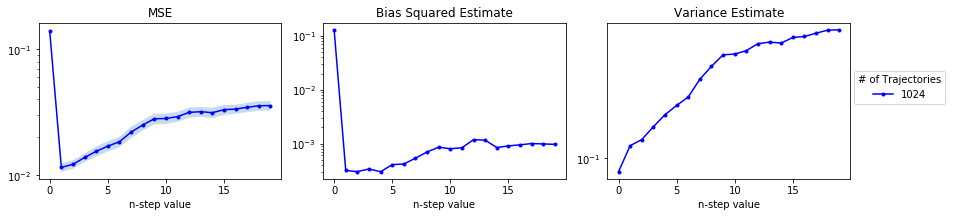

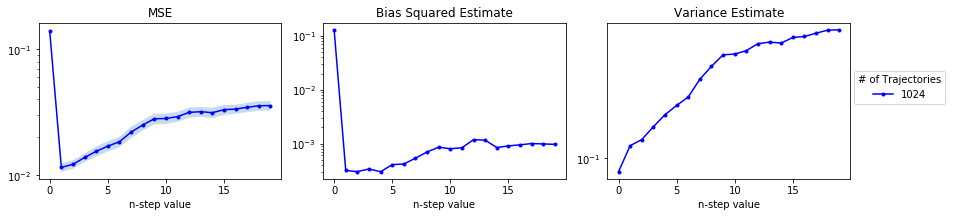

In [42]:

# Run trials.
behavior_policies = [0.1]
max_kl_divergence = get_kl_max(behavior_policies[0], 50)
kl_divergence = [0.1, 0.3] #np.linspace(0, max_kl_divergence, 10)
weighted_results = []
unweighted_results = []
# Uses KL divergence to calculate the evaluation policy
count = 0
for i in behavior_policies:
        
    for k in kl_divergence:
            # Set the behaviour policy
            print("Running ", k, " of ", kl_divergence)

            unweighted_graph_args["p0"] = i
            weighted_graph_args["p0"] = i
            # Change Nvalues to only one measure
            unweighted_graph_args["Nvals"] = [1024]
            weighted_graph_args["Nvals"] = [1024]

            # unweighted_graph_results = run(unweighted_graph_args,k)
            weighted_graph_results = run(weighted_graph_args, k)

            # Save results
            weighted_results.append({"behavior_policy":  i,
                            "kl_divergence": k,
                            "results": weighted_graph_results
                            })
            
            # unweighted_results.append({"behavior_policy":  i,
            #                 "kl_divergence": k,
            #                 "results": unweighted_graph_results, 
            #                 })
            
            # # Plot 
            # neurips_plot(unweighted_graph_results, "unweighted_graph_plot_ep_" + str(i).replace(".", "") + "kl_"+ str(k).replace(".", ""), cycler_small=True)
            neurips_plot(weighted_graph_results, "weighted_graph_plot"+ str(i).replace(".", "") + "kl_"+ str(k).replace(".", ""), cycler_small=True)


In [43]:
print(weighted_results)

[{'behavior_policy': 0.1, 'kl_divergence': 0.1, 'results': ([{'ON POLICY': [-8.261065026146548, 0], 'NStep(t=0)': [-8.543745987472604, 0.07990852589622324], 'NStep(t=1)': [-8.20014067265289, 0.0037117768486203454], 'NStep(t=2)': [-8.222091012200208, 0.0015189737630895508], 'NStep(t=3)': [-8.228947983752834, 0.001031504412119668], 'NStep(t=4)': [-8.219623493824876, 0.001717400601168178], 'NStep(t=5)': [-8.236431313389849, 0.0006068198041795829], 'NStep(t=6)': [-8.185963108967812, 0.005640297963921811], 'NStep(t=7)': [-8.118432682945217, 0.020343985327102337], 'NStep(t=8)': [-8.059642934672489, 0.040570858933784364], 'NStep(t=9)': [-8.08816271061227, 0.02989521071711516], 'NStep(t=10)': [-8.047677735235046, 0.04553413592254998], 'NStep(t=11)': [-8.051866465854985, 0.04376403762806278], 'NStep(t=12)': [-8.118164113672991, 0.020420670785775252], 'NStep(t=13)': [-8.21924175417142, 0.0017491860787055018], 'NStep(t=14)': [-8.240052078240685, 0.0004415439796945099], 'NStep(t=15)': [-8.19584951

In [44]:
# Save data in case of wrong plotting
def default(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, np.int64):
        return int(obj)
    if isinstance(obj, np.int32):
        return int(obj)
    raise TypeError('Not serializable ', obj)


with open("weighted_results.json", "w") as weighted:
        json.dump(weighted_results, weighted, indent = 4, default=default)
weighted.close()

# with open("unweighted_results.json", "w") as unweighted:
#         json.dump(unweighted_results, unweighted, indent=4, default=default)
# unweighted.close()

In [45]:
# if plot failed load data from old file
# Opening JSON file
# with open('weighted_results.json') as weighted_json_file:
#     weighted_results = json.load(weighted_json_file)
# weighted_json_file.close()

# with open('unweighted_results.json') as unweighted_json_file:
#     unweighted_results = json.load(unweighted_json_file)
# unweighted_json_file.close()

In [91]:
def format_results_kl_2d(raw_results, weighted=True):
    R = []
    kl_divergence = []
    for r in raw_results:
        kl_divergence.append(r["kl_divergence"])
        R.append(format_results(r["results"]))

    estimate_means  = []
    estimate_ses    = []
    error_means     = []
    error_ses       = []
    estimate_vars   = []
    my_mse          = []
    seeds           = []

    for i in range(len(R['nvals'])):
        esm = []
        ess = []
        erm = []
        ers = []
        esv = []
        mmse = []
        seed = []
        for [k,r] in zip(kl_divergence, R):
            esm.append(r['ests_mn'][i])
            ess.append(r['ests_se'][i]) 
            erm.append(r['errs_mn'][i])
            ers.append(r['errs_se'][i])
            esv.append(r['ests_var'][i])
            mmse.append(r['my_mse'][i])
            seed.append(r['seeds'][i])
        estimate_means.append(np.array(esm).flatten())
        estimate_ses.append(np.array(ess).flatten())
        error_means.append(np.array(erm).flatten())
        error_ses.append(np.array(ers).flatten())
        estimate_vars.append(np.array(esv).flatten())
        my_mse.append(np.array(mmse).flatten())
        seeds.append(np.array(seed).flatten())
    
    return {
        'seeds'   : np.unique(seeds),
        'kl_div': np.array(kl_divergence),
        'nvals'   : list(R[0]['nvals']),
        'true_val': R[0]['true_val'],
        'ests_mn' : np.array(estimate_means),
        'ests_se' : np.array(estimate_ses),
        'errs_mn' : np.array(error_means),
        'errs_se' : np.array(error_ses),
        "ests_var": np.array(estimate_vars),
        'my_mse'  : np.array(my_mse)}

In [89]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from neurips_plotting import get_cyclers, format_results

def neurips_plot_kl_3D(raw_results, filename, cycler_small=False):

    clean_results = format_results_kl_2d(raw_results)
    print(clean_results)
    linecycler, markercycler, colorcycler = get_cyclers(small=cycler_small)

    horizon = raw_results[0]['results'][1]['args']['horizon']
    nstep_int = raw_results[0]['results'][1]['args'].get('nstep_int', 1)

    for (errs, errs_se, kl_div, ests, ests_var, nval) in zip( clean_results['errs_mn'], clean_results['errs_se'], clean_results['kl_div'], clean_results['ests_mn'], clean_results['ests_var'], clean_results['nvals']):
        color = next(colorcycler)
        linestyle = next(linecycler)
        marker = next(markercycler)

        # Generate sample data
        n_step_int = np.arange(0, horizon, nstep_int)
        kl_div =  clean_results['kl_div']
        z_axis = [errs,abs(ests - clean_results["true_val"])**2, ests_var]
        z_names = ["MSE", "Bias Squared Estimate", "Variance Estimate"]
        # Create a grid of coordinates
        X, Y = np.meshgrid(n_step_int, kl_div)
        
        c1 ,c2 = X.shape
        print(n_step_int)
        print(kl_div)
        print(X.shape)
        print(Y.shape)

        # Reshape the kl_div data to match the grid shape
        Z = [i.reshape(X.shape) for i in z_axis]
        print(Z.shape)
        # Create three subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': '3d'})

        # Set different viewing angles for each subplot
        viewing_angles = [(30, 45), (60, 120), (90, 180)]

        for i, ax in enumerate(axes):
            ax.plot_surface(X,Y , Z[i], cmap='viridis')
            ax.view_init(elev=viewing_angles[0][0], azim=viewing_angles[0][1])
            ax.set_xlabel('n_step_int')
            ax.set_ylabel('KL divergence')
            ax.set_zscale('log')
            ax.set_zlabel(z_names[i])
            ax.set_title('Graph {}'.format(z_names[i]))

        # Adjust spacing between subplots
        plt.tight_layout()

        # Show the plot
        plt.show()
        fig.savefig(filename + "_nval_" + str(nval).replace(".", ""))

In [92]:
neurips_plot_kl_3D(raw_results=weighted_results, filename="weighted_graph_plot_kl_3D", cycler_small=True)
# neurips_plot_kl_3D(raw_results=unweighted_results,filename= "unweighted_graph_plot_kl_3D", cycler_small=True)

# neurips_plot_kl_2D(raw_results=weighted_results, filename="weighted_graph_plot_kl_2D", cycler_small=True)
# neurips_plot_kl_2D(raw_results=unweighted_results,filename= "unweighted_graph_plot_kl_2D", cycler_small=True)

AttributeError: 'numpy.ndarray' object has no attribute 'append'